# Prose Kaleidoscopes - Softmax Experiment

In [8]:
# Imports

from collections import Counter

import copy
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import torch.nn as nn

from torch_rnn_classifier import TorchRNNClassifier
from torch_tree_nn import TorchTreeNN
import sst

# If Jupyter complains that torch is an unknown module, try:
# conda install pytorch torchvision -c pytorch
import torch

# Transformers
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from transformers import BertModel

%matplotlib inline

# Own files
import dataset_io


# These params should never change
NUM_EPOCHS = 4
BATCH_SIZE = 8
LEARNING_RATE = 4e-5
NUM_WARMUP_STEPS = 100
MAX_SEQ_LEN = 512

# Constants
DATASET_TYPE_IMDB = "imdb"
DATASET_TYPE_AMAZON = "amazon"
DATASET_TYPE_SST2 = "sst2"


In [9]:
# Load datasets.
def normalize_list_labels(lst, dataset_type):
    if dataset_type == DATASET_TYPE_IMDB:
        # Labels are either "positive" or "negative"
        return [0 if v == "negative" else 1 for v in lst]
    if dataset_type == DATASET_TYPE_AMAZON:
        # Labels are in the range [1, 5]
        return [(v - 1) * (1.0 / 5) for v in lst]
    # SST-2 are 0 (negative) or 1 (positive).
    return lst

def normalize_labels(df, label_field):
    labels = getattr(df, label_field).to_numpy()
    # Fix IMDB labels.
    is_imdb = len(set(labels)) == 2 and not str(labels[0]).isdigit() and "positive" in labels and "negative" in labels
    # Fix Amazon labels.
    is_amazon = len(set(labels)) == 5 and min(set(labels)) == 1 and max(set(labels)) == 5
    if is_imdb:
        return pd.get_dummies(labels)["positive"]  # 0 is neg, 1 is pos
    if is_amazon:
        return labels - 1
    return labels


def unigrams_phi(text):
    return Counter(text.lower().split())

def get_ngrams_count(text, n):
    words = text.lower().split()
    #return Counter(zip(*[words.lower().split()[i:n+i] for i in range(len(words.split()) - n - 1)]))
    return Counter(zip(*[words[i:] for i in range(n)]))


def fit_softmax_classifier(X, y):
    if DATASET_TYPE != DATASET_TYPE_AMAZON:
        solver='sag'
        class_weights = 'balanced'
        multi_class = 'multinomial'
    else:
        solver='sag'
        multi_class = 'multinomial'
        class_weights = {
            1 : 1.0 / 0.0431,
            2 : 1.0 / 0.0465, 
            3 : 1.0 / 0.1049,
            4 : 1.0 / 0.2556,
            5 : 1.0 / 0.5499
        }
    mod = LogisticRegression(
        fit_intercept=True,
        class_weight=class_weights,
        solver=solver,
        max_iter=10,
        verbose=1,
        multi_class='multinomial')
    mod.fit(X, y)
    return mod

In [10]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def get_roc_metrics(probs, y_true, num_classes, dataset_type):
    preds = np.array(probs)
    if dataset_type != DATASET_TYPE_AMAZON:
        fpr, tpr, threshold = roc_curve(y_true, preds)
        roc_auc = auc(fpr, tpr)
        
        # Get accuracy over the test set
        y_pred = np.where(preds >= 1.0 / num_classes, 1, 0)
        accuracy = accuracy_score(y_true, y_pred)
        return { 
            'fpr' : fpr, 
            'tpr' : tpr, 
            'roc_auc' : roc_auc, 
            'accuracy' : accuracy
        }
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Force any empty categories to be present
    cat_preds = pd.DataFrame(preds)
    cat_preds = cat_preds.astype(pd.CategoricalDtype(categories=list([round(i / num_classes, 1) for i in range(num_classes)])))
    y_true = pd.get_dummies(y_true).to_numpy()
    preds = pd.get_dummies(cat_preds).to_numpy()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], preds[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), preds.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(NUM_CLASSES):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= num_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    y_pred = np.where(preds >= 1.0 / num_classes, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    metrics = {'accuracy' : accuracy}
    for k in fpr.keys():
        metrics["fpr_{0}".format(k)] = fpr[k]
        metrics["tpr_{0}".format(k)] = tpr[k]
        metrics["roc_auc_{0}".format(k)] = roc_auc[k]
    return metrics
    
def evaluate_roc_twoclass(probs, y_true, num_classes, dataset_type):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    fpr, tpr, roc_auc, accuracy = list(get_roc_metrics(probs, y_true, num_classes, dataset_type).values())
    print(f'AUC: {roc_auc:.4f}')
    print(f'Accuracy: {accuracy*100:.4f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
def evaluate_roc_multiclass(probs, y_true, num_classes, dataset_type):
    metrics = get_roc_metrics(probs, y_true, num_classes, dataset_type)
    ks = ["macro", "micro"] + [i for i in range(num_classes)]
    fpr = { k : metrics["fpr_{0}".format(k)] for k in ks }
    tpr = { k : metrics["tpr_{0}".format(k)] for k in ks }
    roc_auc = { k : metrics["roc_auc_{0}".format(k)] for k in ks }
    accuracy = metrics['accuracy']
    
    print(f'AUC: {0}', roc_auc)
    print(f'Accuracy: {accuracy*100:.4f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr["micro"], tpr["micro"], 'b', label = 'Micro-avg AUC = %0.2f' % roc_auc["micro"], color = 'navy')
    plt.plot(fpr["macro"], tpr["macro"], 'b', label = 'Macro-avg AUC = %0.2f' % roc_auc["macro"], color = 'darkviolet')
    colors = ['orange', 'forestgreen', 'cornflowerblue', 'darkgoldenrod', 'tomato', 'dodgerblue']
    lw=2
    for i, color in zip(range(NUM_CLASSES), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='AUC of class {0} = {1:0.2f})'.format(i, roc_auc[i]))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def evaluate_roc(probs, y_true, num_classes, dataset_type):
    if dataset_type == DATASET_TYPE_AMAZON:
        evaluate_roc_multiclass(probs, y_true, num_classes, dataset_type)
    else:
        evaluate_roc_twoclass(probs, y_true, num_classes, dataset_type)

In [11]:
# Execution and Metrics
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import accuracy_score, balanced_accuracy_score, cohen_kappa_score
from sklearn.metrics import roc_auc_score

# Get predictions from the probabilities
def get_pred(value, num_classes):
    interval = 1.0 / num_classes
    for i in range(0, num_classes):
        if value < (i + 1) * interval:
            return i
    return num_classes - 1

def run_and_eval(train, test, text_field, label_field, test_labels, num_classes, dataset_type):
    softmax_experiment = sst.experiment(
        train,
        unigrams_phi,
        fit_softmax_classifier,
        assess_dataframes=[test], 
        text_field=text_field,
        label_field=label_field)
    
    # Evaluate on test set
    test_probs = softmax_experiment['predictions'][0]
    test_probs_norm = normalize_list_labels(test_probs, dataset_type)

    # Evaluate the  classifier
    print("\nTest set")
    evaluate_roc(test_probs_norm, test_labels, num_classes, dataset_type)

    test_preds = np.array([get_pred(p, num_classes) for p in test_probs_norm])
    return copy.deepcopy(test_preds)

def get_metrics_report(train, test, test_preds, test_labels, 
                       train_path, test_path, label_field,
                       dataset_type, expr_type, num_samples, run_id, report_destpath=None):
    metrics_report = classification_report(test_labels, test_preds, output_dict=True, digits=4)
    run_report = { 
        "dataset" : dataset_type, 
        "expr" : expr_type,
        "num_samples" : num_samples, 
        "run_id" : run_id
    }
    metrics_report.update(run_report)

    report_str = "### Softmax | Dataset: {0}, Expr: {1}, N{2}, R{3}\n".format(dataset_type, expr_type, num_samples, run_id)
    report_str += "```\n"
    report_str += "Train: {0}\nTest: {1}\n-------------------------------\n".format(train_path, test_path)
    
    if dataset_type != DATASET_TYPE_AMAZON:
        report_str += "AUC: {0:.4f}\n".format(roc_auc_score(test_labels, test_preds, multi_class='ovr'))
    report_str += "Accuracy:\t{0:.4f}\t\tBalanced Acc: {1:.4f}\n".format(
        accuracy_score(test_preds, test_labels), balanced_accuracy_score(test_preds, test_labels))
    report_str += "Kappa:\t{0}\n".format(cohen_kappa_score(test_preds, test_labels))
    report_str += classification_report(_TEST_LABELS, test_preds, digits=4)
    report_str += "\n"
    report_str += "Train distribution:\t{0}\nTest distribution:\t{1}\n".format(
        getattr(train, label_field).value_counts().to_dict(),
        getattr(test, label_field).value_counts().to_dict())
    labels = [0, 1] if dataset_type != DATASET_TYPE_AMAZON else [0, 1,2 , 3, 4]
    cm = multilabel_confusion_matrix(test_labels, test_preds, labels=labels)
    report_str += "Confusion matrix:\n\t{0}".format(
        "\n\t".join(["Label {0}: TP {1}, FP {2}, TN {3}, FN {4}".format(
            labels[i], cm[i][1][1], cm[i][0][1], cm[i][0][0], cm[i][1][0]) for i in range(len(cm))]))
    report_str += "\n```\n\n"

    if report_destpath is not None:
        file_obj = open(report_destpath, 'a')
        file_obj.write(report_str)
        file_obj.close()

In [12]:
def get_train_path(expr_type, num_samples, run_id, dataset_filename, file_ext):
    return "expr_data/{0}/{1}/r{2}/expr_{0}_n{1}_r{2}_{3}.{4}".format(
        expr_type, num_samples, run_id, dataset_filename, file_ext)

"""
# SST-2
DATASET_FILENAME = "sst2_train"
DATASET_TYPE = "sst2"
FILE_EXT = "tsv"
LABEL_FIELD = "label"
TEXT_FIELD = "sentence"
TEST_PATH = "expr_data/devtest/{0}_test.{1}".format(DATASET_TYPE, FILE_EXT)
"""

"""
# IMDB
DATASET_FILENAME = "imdb"
DATASET_TYPE = "imdb"
FILE_EXT = "csv"
LABEL_FIELD = "sentiment"
TEXT_FIELD = "review"
TEST_PATH = "expr_data/devtest/{0}_test.{1}".format(DATASET_FILENAME, FILE_EXT)
"""

#"""
# Amazon Reviews
DATASET_FILENAME = "amazon_reviews_digital_music"
DATASET_TYPE = "amazon"
FILE_EXT = "json"
LABEL_FIELD = "overall"
TEXT_FIELD = "reviewText"
OUTPUT_RESULTS_PATH = "results/amazon_results.json"
TEST_PATH = "expr_data/devtest/{0}_test.{1}".format(DATASET_FILENAME, FILE_EXT)
#"""


TEST = dataset_io.to_df(TEST_PATH)
_TEST_LABELS = normalize_labels(TEST, LABEL_FIELD)
NUM_CLASSES = len(set(getattr(TEST, LABEL_FIELD)))

### Experiment Changes Start Here

In [14]:
# NUM_SAMPLES can be 10 or 50.
NUM_SAMPLES = 10

RESULTS_DIR = "results"
if not os.path.exists(RESULTS_DIR):
    os.mkdir(RESULTS_DIR)

REPORT_RESULTS_PATH = "{0}/{1}_{2}_softmax_report.md".format(RESULTS_DIR, DATASET_TYPE, NUM_SAMPLES)

if not os.path.exists(REPORT_RESULTS_PATH):
    open(REPORT_RESULTS_PATH, 'a').close()
    print("Metrics report will be written to {0}".format(REPORT_RESULTS_PATH))
else:
    print("Metrics report will be appended to {0}".format(REPORT_RESULTS_PATH))

Metrics report will be written to results/amazon_10_softmax_report.md


Loading training set at expr_data/orig/10/r0/expr_orig_n10_r0_amazon_reviews_digital_music.json


Running amazon experiment on orig, N10, run# 0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.133     0.059     0.082       220
           2      0.000     0.000     0.000       201
           3      0.000     0.000     0.000       604
           4      0.291     0.182     0.224      1662
           5      0.603     0.849     0.705      3783

    accuracy                          0.545      6470
   macro avg      0.205     0.218     0.202      6470
weighted avg      0.432     0.545     0.472      6470


Test set
AUC: 0 {'macro': 0.510531489850089, 'micro': 0.7064335394126738, 0: 0.5227454545454545, 1: 0.4999202424629127, 2: 0.49965905216501877, 3: 0.5, 4: 0.5303327000770591}
Accuracy: 49.8145%


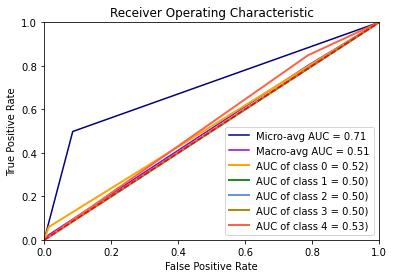

Loading training set at expr_data/orig/10/r1/expr_orig_n10_r1_amazon_reviews_digital_music.json


Running amazon experiment on orig, N10, run# 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.000     0.000     0.000       220
           2      0.000     0.000     0.000       201
           3      0.130     0.005     0.010       604
           4      0.283     0.200     0.235      1662
           5      0.614     0.854     0.714      3783

    accuracy                          0.551      6470
   macro avg      0.205     0.212     0.192      6470
weighted avg      0.444     0.551     0.479      6470


Test set
AUC: 0 {'macro': 0.5098712091906554, 'micro': 0.710239567233385, 0: 0.49952, 1: 0.5, 2: 0.500778704533703, 3: 0.5, 4: 0.5490573414195743}
Accuracy: 50.0000%


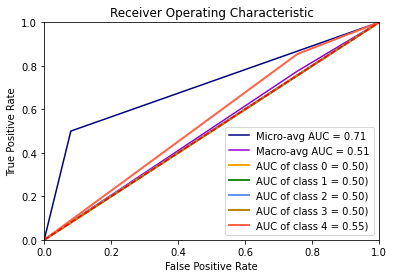

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/

Loading training set at expr_data/orig/10/r2/expr_orig_n10_r2_amazon_reviews_digital_music.json


Running amazon experiment on orig, N10, run# 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.000     0.000     0.000       220
           2      0.000     0.000     0.000       201
           3      0.000     0.000     0.000       604
           4      0.298     0.301     0.299      1662
           5      0.630     0.796     0.703      3783

    accuracy                          0.543      6470
   macro avg      0.186     0.219     0.201      6470
weighted avg      0.445     0.543     0.488      6470


Test set
AUC: 0 {'macro': 0.5136218492387468, 'micro': 0.6984930448222566, 0: 0.49976, 1: 0.4998404849258255, 2: 0.49982952608250936, 3: 0.5, 4: 0.5686792351853989}
Accuracy: 46.5688%


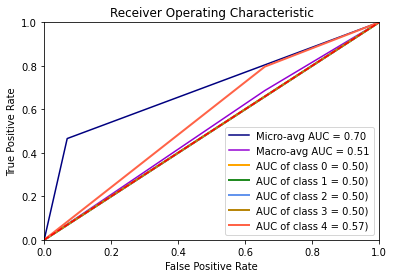

Loading training set at expr_data/orig/10/r3/expr_orig_n10_r3_amazon_reviews_digital_music.json


Running amazon experiment on orig, N10, run# 3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.250     0.005     0.009       220
           2      0.125     0.020     0.034       201
           3      0.066     0.007     0.012       604
           4      0.284     0.099     0.147      1662
           5      0.593     0.908     0.718      3783

    accuracy                          0.558      6470
   macro avg      0.264     0.208     0.184      6470
weighted avg      0.438     0.558     0.460      6470


Test set
AUC: 0 {'macro': 0.504749243667416, 'micro': 0.7189914992272024, 0: 0.5020327272727273, 1: 0.5077170377177758, 2: 0.4984527516296629, 3: 0.5, 4: 0.5155437017169144}
Accuracy: 53.2457%


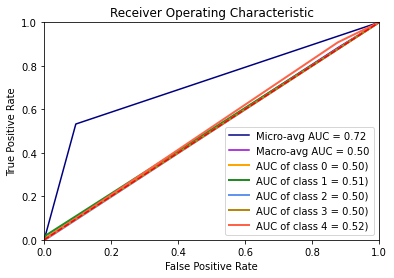

Loading training set at expr_data/orig/10/r4/expr_orig_n10_r4_amazon_reviews_digital_music.json


Running amazon experiment on orig, N10, run# 4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.105     0.068     0.083       220
           2      0.047     0.085     0.060       201
           3      0.114     0.017     0.029       604
           4      0.280     0.008     0.016      1662
           5      0.580     0.893     0.703      3783

    accuracy                          0.531      6470
   macro avg      0.225     0.214     0.178      6470
weighted avg      0.426     0.531     0.423      6470


Test set
AUC: 0 {'macro': 0.5061598430271869, 'micro': 0.7062403400309119, 0: 0.523850909090909, 1: 0.5146924493817402, 2: 0.50162966291323, 3: 0.5, 4: 0.4906261937500547}
Accuracy: 52.8439%


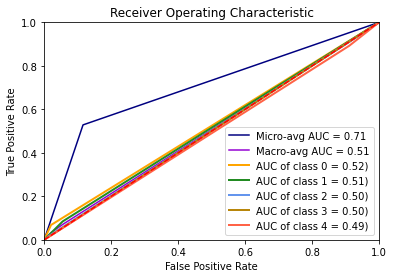

Loading training set at expr_data/orig/10/r5/expr_orig_n10_r5_amazon_reviews_digital_music.json


Running amazon experiment on orig, N10, run# 5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.250     0.005     0.009       220
           2      0.000     0.000     0.000       201
           3      0.000     0.000     0.000       604
           4      0.291     0.015     0.029      1662
           5      0.586     0.989     0.736      3783

    accuracy                          0.582      6470
   macro avg      0.225     0.202     0.155      6470
weighted avg      0.426     0.582     0.438      6470


Test set
AUC: 0 {'macro': 0.5011039590583768, 'micro': 0.7381375579598145, 0: 0.5020327272727273, 1: 0.4999202424629127, 2: 0.5, 3: 0.5, 4: 0.5035668255562439}
Accuracy: 57.8362%


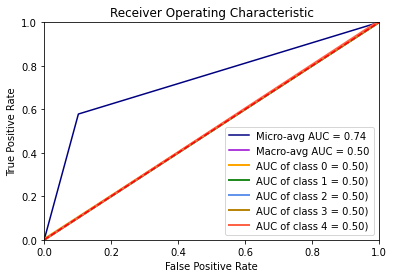

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/

Loading training set at expr_data/orig/10/r6/expr_orig_n10_r6_amazon_reviews_digital_music.json


Running amazon experiment on orig, N10, run# 6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.333     0.005     0.009       220
           2      0.091     0.005     0.009       201
           3      0.000     0.000     0.000       604
           4      0.293     0.419     0.345      1662
           5      0.624     0.672     0.647      3783

    accuracy                          0.501      6470
   macro avg      0.268     0.220     0.202      6470
weighted avg      0.454     0.501     0.468      6470


Test set
AUC: 0 {'macro': 0.5108926333676314, 'micro': 0.6668083462132921, 0: 0.5021127272727273, 1: 0.5016899868181822, 2: 0.5, 3: 0.5, 4: 0.5506604527472472}
Accuracy: 39.3354%


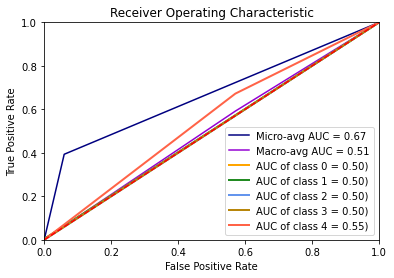

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/

Loading training set at expr_data/orig/10/r7/expr_orig_n10_r7_amazon_reviews_digital_music.json


Running amazon experiment on orig, N10, run# 7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.000     0.000     0.000       220
           2      0.500     0.005     0.010       201
           3      0.000     0.000     0.000       604
           4      0.339     0.024     0.045      1662
           5      0.588     0.987     0.737      3783

    accuracy                          0.583      6470
   macro avg      0.285     0.203     0.158      6470
weighted avg      0.446     0.583     0.443      6470


Test set
AUC: 0 {'macro': 0.5018063794777894, 'micro': 0.7379829984544048, 0: 0.49992, 1: 0.5024078046519675, 2: 0.4999147630412547, 3: 0.5, 4: 0.5067893296957251}
Accuracy: 57.7125%


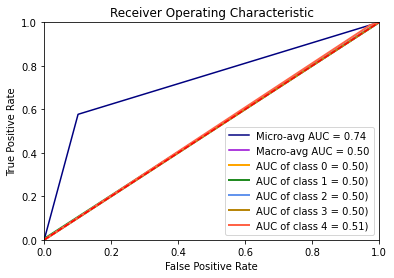

Loading training set at expr_data/orig/10/r8/expr_orig_n10_r8_amazon_reviews_digital_music.json


Running amazon experiment on orig, N10, run# 8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.048     0.355     0.085       220
           2      0.000     0.000     0.000       201
           3      0.000     0.000     0.000       604
           4      0.260     0.040     0.069      1662
           5      0.567     0.676     0.617      3783

    accuracy                          0.418      6470
   macro avg      0.175     0.214     0.154      6470
weighted avg      0.400     0.418     0.381      6470


Test set
AUC: 0 {'macro': 0.5042753210401292, 'micro': 0.6345440494590417, 0: 0.5535927272727272, 1: 0.49393842718136866, 2: 0.4999147630412547, 3: 0.5, 4: 0.4739306877052955}
Accuracy: 40.7419%


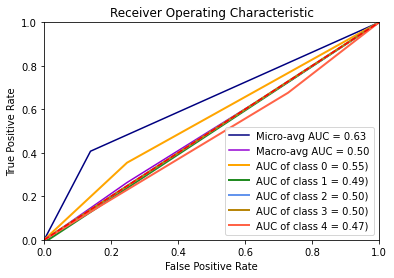

Loading training set at expr_data/orig/10/r9/expr_orig_n10_r9_amazon_reviews_digital_music.json


Running amazon experiment on orig, N10, run# 9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.083     0.005     0.009       220
           2      0.333     0.005     0.010       201
           3      0.124     0.020     0.034       604
           4      0.334     0.193     0.244      1662
           5      0.619     0.883     0.728      3783

    accuracy                          0.568      6470
   macro avg      0.299     0.221     0.205      6470
weighted avg      0.472     0.568     0.492      6470


Test set
AUC: 0 {'macro': 0.5129326066226969, 'micro': 0.71758114374034, 0: 0.5013927272727273, 1: 0.5023280471148802, 2: 0.5026886333410856, 3: 0.5, 4: 0.5582536253847914}
Accuracy: 51.8547%


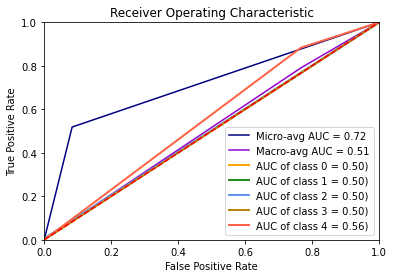

Loading training set at expr_data/orig/10/r10/expr_orig_n10_r10_amazon_reviews_digital_music.json


Running amazon experiment on orig, N10, run# 10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.035     0.014     0.020       220
           2      0.000     0.000     0.000       201
           3      0.053     0.017     0.025       604
           4      0.298     0.602     0.399      1662
           5      0.657     0.492     0.563      3783

    accuracy                          0.445      6470
   macro avg      0.209     0.225     0.201      6470
weighted avg      0.467     0.445     0.435      6470


Test set
AUC: 0 {'macro': 0.5117122885922449, 'micro': 0.6211360123647603, 0: 0.5002581818181818, 1: 0.4999202424629127, 2: 0.4930207300799534, 3: 0.5, 4: 0.565362288600177}
Accuracy: 28.9954%


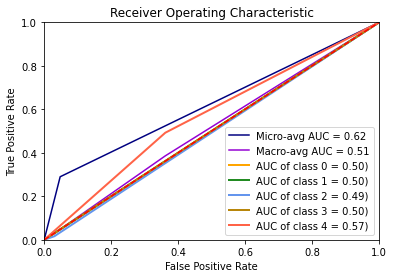

Loading training set at expr_data/orig/10/r11/expr_orig_n10_r11_amazon_reviews_digital_music.json


Running amazon experiment on orig, N10, run# 11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.133     0.018     0.032       220
           2      0.048     0.005     0.009       201
           3      0.101     0.036     0.054       604
           4      0.317     0.202     0.247      1662
           5      0.613     0.833     0.706      3783

    accuracy                          0.543      6470
   macro avg      0.242     0.219     0.209      6470
weighted avg      0.455     0.543     0.483      6470


Test set
AUC: 0 {'macro': 0.5110935870485331, 'micro': 0.7025888717156106, 0: 0.507010909090909, 1: 0.5008924114473097, 2: 0.5015054766157202, 3: 0.5, 4: 0.546059138088727}
Accuracy: 49.1499%


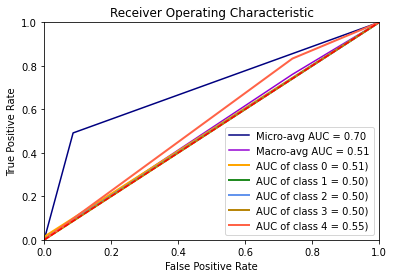

Loading training set at expr_data/para/10/r0/expr_para_n10_r0_amazon_reviews_digital_music.json


Running amazon experiment on para, N10, run# 0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.000     0.000     0.000       220
           2      0.000     0.000     0.000       201
           3      0.000     0.000     0.000       604
           4      0.286     0.660     0.399      1662
           5      0.658     0.457     0.539      3783

    accuracy                          0.437      6470
   macro avg      0.189     0.223     0.188      6470
weighted avg      0.458     0.437     0.418      6470


Test set
AUC: 0 {'macro': 0.5122502013758129, 'micro': 0.6162287480680062, 0: 0.5, 1: 0.5, 2: 0.49982952608250936, 3: 0.5, 4: 0.5614214807965551}
Accuracy: 26.7233%


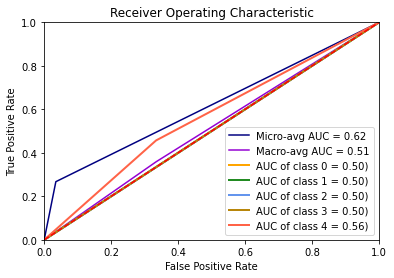

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/

Loading training set at expr_data/para/10/r1/expr_para_n10_r1_amazon_reviews_digital_music.json


Running amazon experiment on para, N10, run# 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.000     0.000     0.000       220
           2      0.000     0.000     0.000       201
           3      0.286     0.003     0.007       604
           4      0.270     0.206     0.233      1662
           5      0.605     0.830     0.699      3783

    accuracy                          0.538      6470
   macro avg      0.232     0.208     0.188      6470
weighted avg      0.449     0.538     0.470      6470


Test set
AUC: 0 {'macro': 0.5067854500253242, 'micro': 0.702936630602782, 0: 0.49984, 1: 0.5, 2: 0.5012294443453462, 3: 0.5, 4: 0.5328578057812747}
Accuracy: 48.5471%


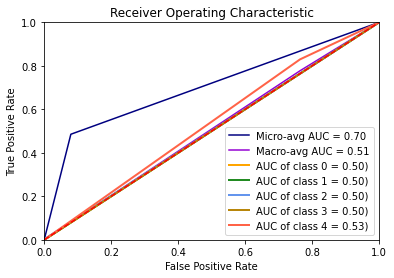

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/

Loading training set at expr_data/para/10/r2/expr_para_n10_r2_amazon_reviews_digital_music.json


Running amazon experiment on para, N10, run# 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.000     0.000     0.000       220
           2      0.000     0.000     0.000       201
           3      0.000     0.000     0.000       604
           4      0.318     0.307     0.312      1662
           5      0.633     0.813     0.712      3783

    accuracy                          0.554      6470
   macro avg      0.190     0.224     0.205      6470
weighted avg      0.452     0.554     0.496      6470


Test set
AUC: 0 {'macro': 0.5148802117316279, 'micro': 0.7031298299845441, 0: 0.49984, 1: 0.4999202424629127, 2: 0.5, 3: 0.5, 4: 0.5746408161952268}
Accuracy: 47.5270%


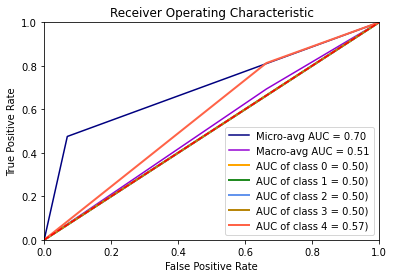

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/

Loading training set at expr_data/para/10/r3/expr_para_n10_r3_amazon_reviews_digital_music.json


Running amazon experiment on para, N10, run# 3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.000     0.000     0.000       220
           2      0.250     0.005     0.010       201
           3      0.000     0.000     0.000       604
           4      0.255     0.055     0.090      1662
           5      0.587     0.945     0.724      3783

    accuracy                          0.567      6470
   macro avg      0.218     0.201     0.165      6470
weighted avg      0.417     0.567     0.447      6470


Test set
AUC: 0 {'macro': 0.5010669078956754, 'micro': 0.727241112828439, 0: 0.49992, 1: 0.502248289577793, 2: 0.49803954994885785, 3: 0.5, 4: 0.5051266999517261}
Accuracy: 55.2550%


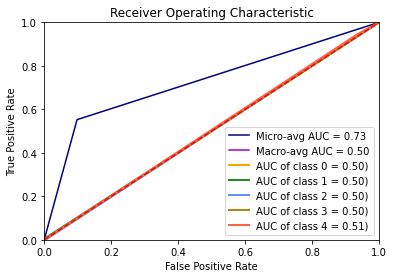

Loading training set at expr_data/para/10/r4/expr_para_n10_r4_amazon_reviews_digital_music.json


Running amazon experiment on para, N10, run# 4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.000     0.000     0.000       220
           2      0.043     0.005     0.009       201
           3      0.000     0.000     0.000       604
           4      0.296     0.034     0.061      1662
           5      0.586     0.968     0.730      3783

    accuracy                          0.575      6470
   macro avg      0.185     0.201     0.160      6470
weighted avg      0.420     0.575     0.443      6470


Test set
AUC: 0 {'macro': 0.5005395666927587, 'micro': 0.7324961360123647, 0: 0.49976, 1: 0.5007328963731352, 2: 0.49940334128878283, 3: 0.5, 4: 0.5028015958018759}
Accuracy: 56.6151%


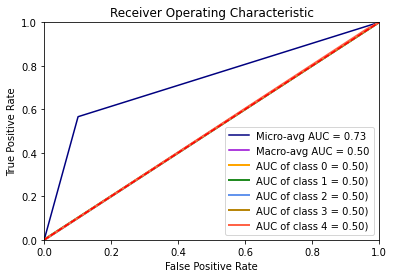

Loading training set at expr_data/para/10/r5/expr_para_n10_r5_amazon_reviews_digital_music.json


Running amazon experiment on para, N10, run# 5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.000     0.000     0.000       220
           2      0.000     0.000     0.000       201
           3      0.000     0.000     0.000       604
           4      0.279     0.010     0.020      1662
           5      0.585     0.990     0.735      3783

    accuracy                          0.582      6470
   macro avg      0.173     0.200     0.151      6470
weighted avg      0.414     0.582     0.435      6470


Test set
AUC: 0 {'macro': 0.5000424771343792, 'micro': 0.7381375579598145, 0: 0.49984, 1: 0.4999202424629127, 2: 0.5, 3: 0.5, 4: 0.5004521432089831}
Accuracy: 57.9134%


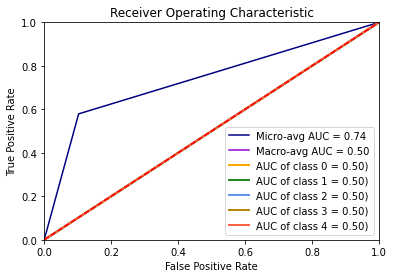

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/

Loading training set at expr_data/para/10/r6/expr_para_n10_r6_amazon_reviews_digital_music.json


Running amazon experiment on para, N10, run# 6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.000     0.000     0.000       220
           2      0.000     0.000     0.000       201
           3      0.250     0.002     0.003       604
           4      0.254     0.042     0.072      1662
           5      0.586     0.958     0.728      3783

    accuracy                          0.571      6470
   macro avg      0.218     0.200     0.161      6470
weighted avg      0.431     0.571     0.444      6470


Test set
AUC: 0 {'macro': 0.5006693625111621, 'micro': 0.7306993817619782, 0: 0.49984, 1: 0.499680969851651, 2: 0.5005721036933004, 3: 0.5, 4: 0.503253739010859}
Accuracy: 56.0587%


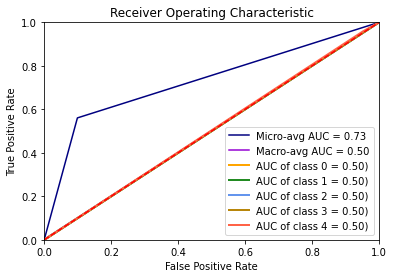

Loading training set at expr_data/para/10/r7/expr_para_n10_r7_amazon_reviews_digital_music.json


Running amazon experiment on para, N10, run# 7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.111     0.005     0.009       220
           2      0.333     0.005     0.010       201
           3      0.000     0.000     0.000       604
           4      0.319     0.031     0.056      1662
           5      0.589     0.980     0.736      3783

    accuracy                          0.581      6470
   macro avg      0.270     0.204     0.162      6470
weighted avg      0.440     0.581     0.445      6470


Test set
AUC: 0 {'macro': 0.5024195752972177, 'micro': 0.7364760432766616, 0: 0.5016327272727273, 1: 0.5023280471148802, 2: 0.5, 3: 0.5, 4: 0.5081371020984816}
Accuracy: 57.3416%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


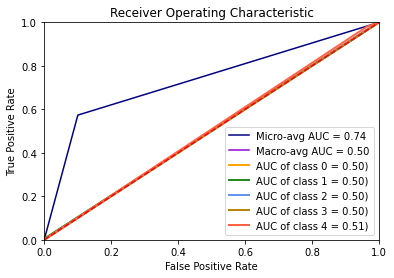

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/

Loading training set at expr_data/para/10/r8/expr_para_n10_r8_amazon_reviews_digital_music.json


Running amazon experiment on para, N10, run# 8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.056     0.036     0.044       220
           2      0.000     0.000     0.000       201
           3      0.000     0.000     0.000       604
           4      0.207     0.015     0.028      1662
           5      0.583     0.947     0.722      3783

    accuracy                          0.559      6470
   macro avg      0.169     0.200     0.159      6470
weighted avg      0.396     0.559     0.431      6470


Test set
AUC: 0 {'macro': 0.49990978173526623, 'micro': 0.7243238021638331, 0: 0.5073018181818182, 1: 0.4953740628489392, 2: 0.4999147630412547, 3: 0.5, 4: 0.4969582646043191}
Accuracy: 55.5178%


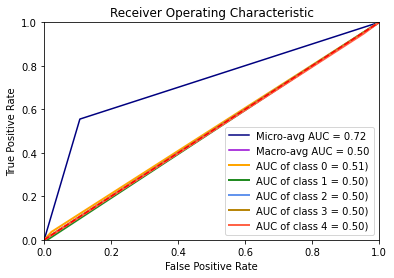

Loading training set at expr_data/para/10/r9/expr_para_n10_r9_amazon_reviews_digital_music.json


Running amazon experiment on para, N10, run# 9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.043     0.005     0.008       220
           2      0.333     0.005     0.010       201
           3      0.128     0.020     0.034       604
           4      0.341     0.146     0.205      1662
           5      0.612     0.912     0.732      3783

    accuracy                          0.573      6470
   macro avg      0.292     0.218     0.198      6470
weighted avg      0.469     0.573     0.485      6470


Test set
AUC: 0 {'macro': 0.5109253829635219, 'micro': 0.7233771251931993, 0: 0.5005127272727273, 1: 0.5023280471148802, 2: 0.5029443442173215, 3: 0.5, 4: 0.5488417962126808}
Accuracy: 53.5394%


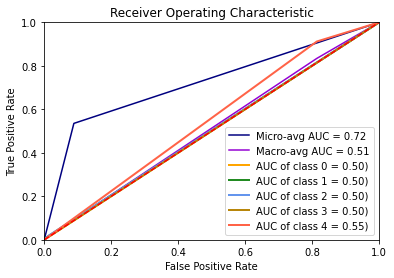

Loading training set at expr_data/para/10/r10/expr_para_n10_r10_amazon_reviews_digital_music.json


Running amazon experiment on para, N10, run# 10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.000     0.000     0.000       220
           2      0.000     0.000     0.000       201
           3      0.094     0.050     0.065       604
           4      0.312     0.367     0.337      1662
           5      0.629     0.695     0.660      3783

    accuracy                          0.505      6470
   macro avg      0.207     0.222     0.212      6470
weighted avg      0.457     0.505     0.479      6470


Test set
AUC: 0 {'macro': 0.5114944280546305, 'micro': 0.669532457496136, 0: 0.4988, 1: 0.4998404849258255, 2: 0.5002861929674428, 3: 0.5, 4: 0.5585454623798847}
Accuracy: 41.0819%


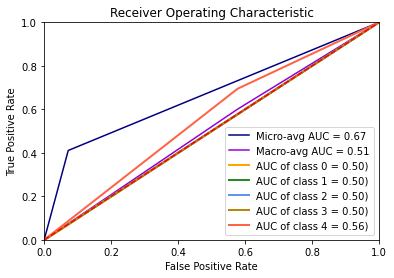

Loading training set at expr_data/para/10/r11/expr_para_n10_r11_amazon_reviews_digital_music.json


Running amazon experiment on para, N10, run# 11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.200     0.009     0.017       220
           2      0.067     0.045     0.054       201
           3      0.118     0.033     0.052       604
           4      0.370     0.129     0.191      1662
           5      0.602     0.888     0.718      3783

    accuracy                          0.557      6470
   macro avg      0.271     0.221     0.206      6470
weighted avg      0.467     0.557     0.476      6470


Test set
AUC: 0 {'macro': 0.5102291677685609, 'micro': 0.7136398763523956, 0: 0.5039054545454545, 1: 0.5123386100284983, 2: 0.5038559845376771, 3: 0.5, 4: 0.5310457897311744}
Accuracy: 52.3957%


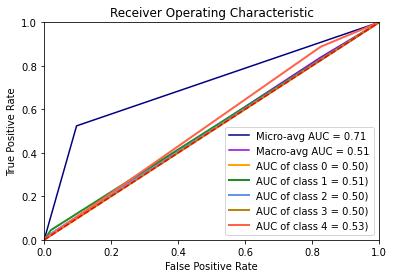

Loading training set at expr_data/para_tc/10/r0/expr_para_tc_n10_r0_amazon_reviews_digital_music.json


Running amazon experiment on para_tc, N10, run# 0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
              precision    recall  f1-score   support

           1      0.083     0.041     0.055       220
           2      0.000     0.000     0.000       201
           3      0.167     0.002     0.003       604
           4      0.275     0.194     0.227      1662
           5      0.598     0.819     0.691      3783

    accuracy                          0.530      6470
   macro avg      0.224     0.211     0.195      6470
weighted avg      0.438     0.530     0.464      6470


Test set
AUC: 0 {'macro': 0.5068044307590529, 'micro': 0.6977782071097373, 0: 0.5124545454545455, 1: 0.5, 2: 0.5004016297758098, 3: 0.5, 4: 0.5211659785649096}
Accuracy: 48.0216%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/

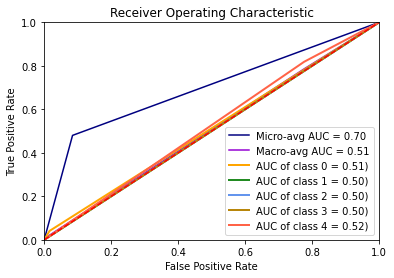

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/

Loading training set at expr_data/para_tc/10/r1/expr_para_tc_n10_r1_amazon_reviews_digital_music.json


Running amazon experiment on para_tc, N10, run# 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
              precision    recall  f1-score   support

           1      0.000     0.000     0.000       220
           2      0.000     0.000     0.000       201
           3      0.158     0.005     0.010       604
           4      0.273     0.229     0.249      1662
           5      0.609     0.812     0.696      3783

    accuracy                          0.534      6470
   macro avg      0.208     0.209     0.191      6470
weighted avg      0.441     0.534     0.472      6470


Test set
AUC: 0 {'macro': 0.5077888199281448, 'micro': 0.6988987635239567, 0: 0.49968, 1: 0.49888339448077845, 2: 0.5011196523686844, 3: 0.5, 4: 0.5392610527912612}
Accuracy: 47.5270%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished


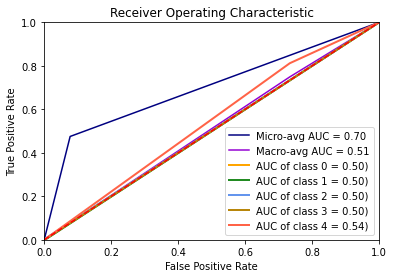

Loading training set at expr_data/para_tc/10/r2/expr_para_tc_n10_r2_amazon_reviews_digital_music.json


Running amazon experiment on para_tc, N10, run# 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
              precision    recall  f1-score   support

           1      0.200     0.005     0.009       220
           2      0.000     0.000     0.000       201
           3      0.000     0.000     0.000       604
           4      0.321     0.324     0.323      1662
           5      0.635     0.800     0.708      3783

    accuracy                          0.551      6470
   macro avg      0.231     0.226     0.208      6470
weighted avg      0.460     0.551     0.497      6470


Test set
AUC: 0 {'macro': 0.5153086375300938, 'micro': 0.7000193199381762, 0: 0.5019527272727273, 1: 0.4988036369436912, 2: 0.4999147630412547, 3: 0.5, 4: 0.575872060392796}
Accuracy: 46.8161%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished


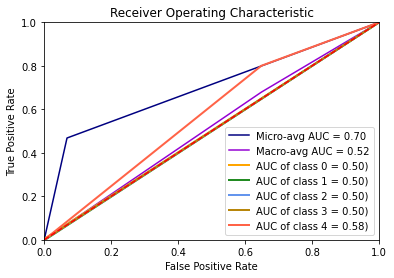

Loading training set at expr_data/para_tc/10/r3/expr_para_tc_n10_r3_amazon_reviews_digital_music.json


Running amazon experiment on para_tc, N10, run# 3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
              precision    recall  f1-score   support

           1      0.000     0.000     0.000       220
           2      0.000     0.000     0.000       201
           3      0.000     0.000     0.000       604
           4      0.284     0.084     0.129      1662
           5      0.595     0.936     0.727      3783

    accuracy                          0.569      6470
   macro avg      0.176     0.204     0.171      6470
weighted avg      0.421     0.569     0.458      6470


Test set
AUC: 0 {'macro': 0.5033845735834873, 'micro': 0.7266228748068007, 0: 0.49984, 1: 0.4998404849258255, 2: 0.49829526082509373, 3: 0.5, 4: 0.5189471221665175}
Accuracy: 54.7450%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


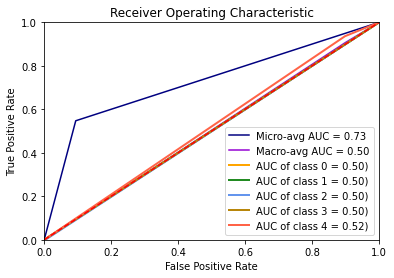

Loading training set at expr_data/para_tc/10/r4/expr_para_tc_n10_r4_amazon_reviews_digital_music.json


Running amazon experiment on para_tc, N10, run# 4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
              precision    recall  f1-score   support

           1      0.000     0.000     0.000       220
           2      0.000     0.000     0.000       201
           3      0.125     0.017     0.029       604
           4      0.288     0.131     0.180      1662
           5      0.598     0.888     0.715      3783

    accuracy                          0.554      6470
   macro avg      0.202     0.207     0.185      6470
weighted avg      0.435     0.554     0.467      6470


Test set
AUC: 0 {'macro': 0.5050447022667159, 'micro': 0.7149922720247296, 0: 0.5, 1: 0.4983250917211676, 2: 0.5023115585831923, 3: 0.5, 4: 0.5245868610292199}
Accuracy: 52.0556%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/

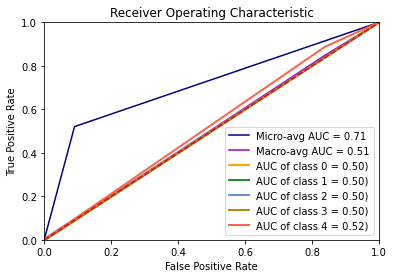

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/

Loading training set at expr_data/para_tc/10/r5/expr_para_tc_n10_r5_amazon_reviews_digital_music.json


Running amazon experiment on para_tc, N10, run# 5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
              precision    recall  f1-score   support

           1      0.250     0.005     0.009       220
           2      0.000     0.000     0.000       201
           3      0.000     0.000     0.000       604
           4      0.344     0.025     0.047      1662
           5      0.588     0.985     0.736      3783

    accuracy                          0.583      6470
   macro avg      0.236     0.203     0.158      6470
weighted avg      0.441     0.583     0.443      6470


Test set
AUC: 0 {'macro': 0.50161628965101, 'micro': 0.7375772797527048, 0: 0.5020327272727273, 1: 0.4999202424629127, 2: 0.5, 3: 0.5, 4: 0.5061284785194101}
Accuracy: 57.6352%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/

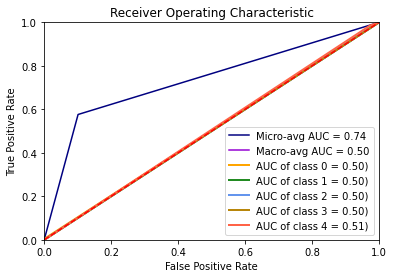

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/

Loading training set at expr_data/para_tc/10/r6/expr_para_tc_n10_r6_amazon_reviews_digital_music.json


Running amazon experiment on para_tc, N10, run# 6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
              precision    recall  f1-score   support

           1      0.000     0.000     0.000       220
           2      0.200     0.005     0.010       201
           3      0.138     0.013     0.024       604
           4      0.294     0.157     0.205      1662
           5      0.599     0.873     0.711      3783

    accuracy                          0.552      6470
   macro avg      0.246     0.210     0.190      6470
weighted avg      0.445     0.552     0.471      6470


Test set
AUC: 0 {'macro': 0.5058896390742106, 'micro': 0.712210200927357, 0: 0.49984, 1: 0.5021685320407058, 2: 0.5023606686190258, 3: 0.5, 4: 0.5250789947113215}
Accuracy: 51.2056%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished


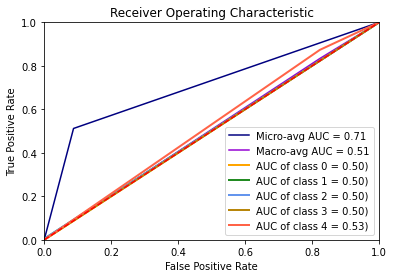

Loading training set at expr_data/para_tc/10/r7/expr_para_tc_n10_r7_amazon_reviews_digital_music.json


Running amazon experiment on para_tc, N10, run# 7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
              precision    recall  f1-score   support

           1      0.069     0.018     0.029       220
           2      0.071     0.005     0.009       201
           3      0.000     0.000     0.000       604
           4      0.286     0.075     0.119      1662
           5      0.593     0.934     0.725      3783

    accuracy                          0.566      6470
   macro avg      0.204     0.206     0.176      6470
weighted avg      0.424     0.566     0.456      6470


Test set
AUC: 0 {'macro': 0.5042111652282235, 'micro': 0.7251159196290571, 0: 0.504770909090909, 1: 0.5014507142069204, 2: 0.5, 3: 0.5, 4: 0.5148342028432882}
Accuracy: 54.6677%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/

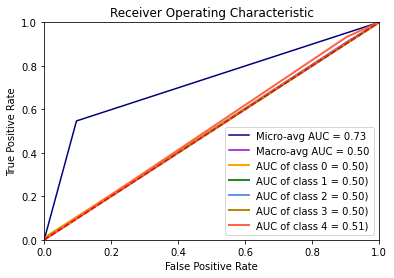

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/

Loading training set at expr_data/para_tc/10/r8/expr_para_tc_n10_r8_amazon_reviews_digital_music.json


Running amazon experiment on para_tc, N10, run# 8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
              precision    recall  f1-score   support

           1      0.054     0.036     0.044       220
           2      0.095     0.010     0.018       201
           3      0.000     0.000     0.000       604
           4      0.265     0.084     0.127      1662
           5      0.586     0.895     0.708      3783

    accuracy                          0.546      6470
   macro avg      0.200     0.205     0.179      6470
weighted avg      0.416     0.546     0.449      6470


Test set
AUC: 0 {'macro': 0.5025995397944418, 'micro': 0.7130023183925811, 0: 0.5070618181818182, 1: 0.5034597311734516, 2: 0.4995738152062734, 3: 0.5, 4: 0.5029023344106659}
Accuracy: 52.4575%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


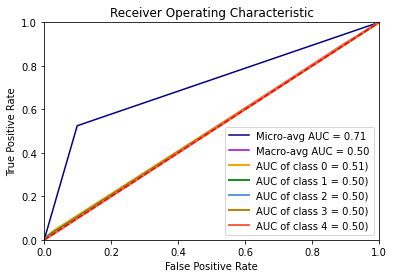

Loading training set at expr_data/para_tc/10/r9/expr_para_tc_n10_r9_amazon_reviews_digital_music.json


Running amazon experiment on para_tc, N10, run# 9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
              precision    recall  f1-score   support

           1      0.000     0.000     0.000       220
           2      0.000     0.000     0.000       201
           3      0.126     0.018     0.032       604
           4      0.346     0.264     0.300      1662
           5      0.635     0.857     0.729      3783

    accuracy                          0.570      6470
   macro avg      0.222     0.228     0.212      6470
weighted avg      0.472     0.570     0.506      6470


Test set
AUC: 0 {'macro': 0.5166887011981867, 'micro': 0.7136398763523957, 0: 0.49944, 1: 0.499680969851651, 2: 0.502627951400257, 3: 0.5, 4: 0.5816945847390255}
Accuracy: 50.2628%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished


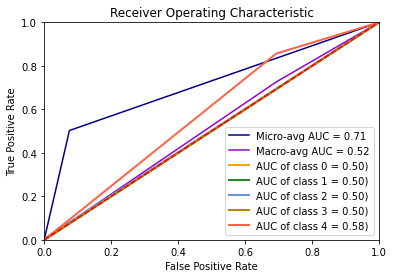

Loading training set at expr_data/para_tc/10/r10/expr_para_tc_n10_r10_amazon_reviews_digital_music.json


Running amazon experiment on para_tc, N10, run# 10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
              precision    recall  f1-score   support

           1      0.071     0.005     0.009       220
           2      0.000     0.000     0.000       201
           3      0.143     0.040     0.062       604
           4      0.302     0.378     0.336      1662
           5      0.630     0.699     0.663      3783

    accuracy                          0.510      6470
   macro avg      0.229     0.224     0.214      6470
weighted avg      0.462     0.510     0.480      6470


Test set
AUC: 0 {'macro': 0.5138226799963821, 'micro': 0.6732225656877898, 0: 0.5012327272727273, 1: 0.499680969851651, 2: 0.5075934276095493, 3: 0.5, 4: 0.5606062752479828}
Accuracy: 41.2674%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished


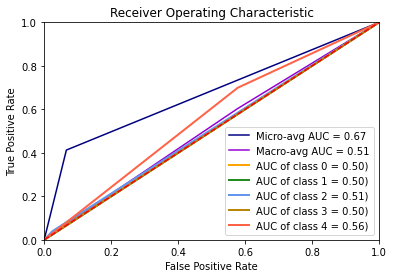

Loading training set at expr_data/para_tc/10/r11/expr_para_tc_n10_r11_amazon_reviews_digital_music.json


Running amazon experiment on para_tc, N10, run# 11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
              precision    recall  f1-score   support

           1      0.364     0.018     0.035       220
           2      0.060     0.020     0.030       201
           3      0.097     0.022     0.035       604
           4      0.328     0.188     0.239      1662
           5      0.616     0.863     0.719      3783

    accuracy                          0.556      6470
   macro avg      0.293     0.222     0.212      6470
weighted avg      0.468     0.556     0.487      6470


Test set
AUC: 0 {'macro': 0.5132305823810652, 'micro': 0.710935085007728, 0: 0.508530909090909, 1: 0.5049255239197218, 2: 0.5004479173957909, 3: 0.5, 4: 0.552248561498904}
Accuracy: 50.8037%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


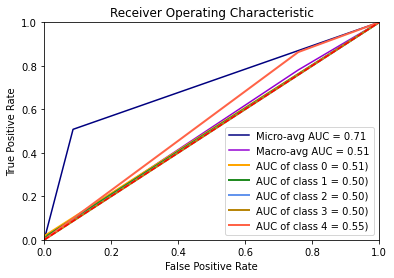

Loading training set at expr_data/para_editdist/10/r0/expr_para_editdist_n10_r0_amazon_reviews_digital_music.json


Running amazon experiment on para_editdist, N10, run# 0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


max_iter reached after 1 seconds
              precision    recall  f1-score   support

           1      0.041     0.573     0.076       220
           2      0.000     0.000     0.000       201
           3      0.000     0.000     0.000       604
           4      0.314     0.174     0.224      1662
           5      0.664     0.429     0.521      3783

    accuracy                          0.315      6470
   macro avg      0.204     0.235     0.164      6470
weighted avg      0.470     0.315     0.365      6470


Test set
AUC: 0 {'macro': 0.5218600146951171, 'micro': 0.5616112828438948, 0: 0.5480436363636364, 1: 0.4999202424629127, 2: 0.4999147630412547, 3: 0.5, 4: 0.5614214316077814}
Accuracy: 27.0170%


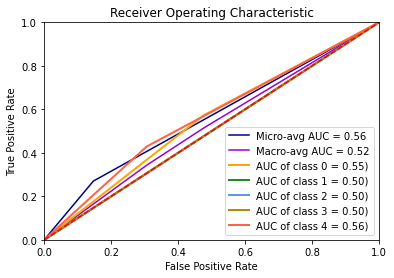

Loading training set at expr_data/para_editdist/10/r1/expr_para_editdist_n10_r1_amazon_reviews_digital_music.json


Running amazon experiment on para_editdist, N10, run# 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.000     0.000     0.000       220
           2      0.200     0.005     0.010       201
           3      0.200     0.002     0.003       604
           4      0.277     0.201     0.233      1662
           5      0.604     0.838     0.702      3783

    accuracy                          0.542      6470
   macro avg      0.256     0.209     0.190      6470
weighted avg      0.449     0.542     0.471      6470


Test set
AUC: 0 {'macro': 0.5068108242134695, 'micro': 0.7046174652241113, 0: 0.4996, 1: 0.5021685320407058, 2: 0.5004868667345552, 3: 0.5, 4: 0.5317987222920867}
Accuracy: 49.0108%


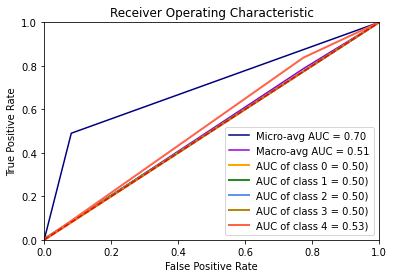

Loading training set at expr_data/para_editdist/10/r2/expr_para_editdist_n10_r2_amazon_reviews_digital_music.json


Running amazon experiment on para_editdist, N10, run# 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.000     0.000     0.000       220
           2      0.000     0.000     0.000       201
           3      0.000     0.000     0.000       604
           4      0.324     0.347     0.335      1662
           5      0.638     0.790     0.706      3783

    accuracy                          0.551      6470
   macro avg      0.192     0.227     0.208      6470
weighted avg      0.456     0.551     0.499      6470


Test set
AUC: 0 {'macro': 0.5157852139321972, 'micro': 0.698048686244204, 0: 0.49976, 1: 0.4999202424629127, 2: 0.4999147630412547, 3: 0.5, 4: 0.5793310641568192}
Accuracy: 46.1824%


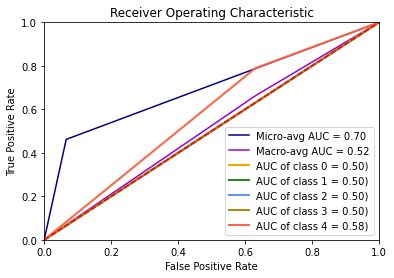

Loading training set at expr_data/para_editdist/10/r3/expr_para_editdist_n10_r3_amazon_reviews_digital_music.json


Running amazon experiment on para_editdist, N10, run# 3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.500     0.005     0.009       220
           2      0.000     0.000     0.000       201
           3      0.030     0.002     0.003       604
           4      0.329     0.074     0.121      1662
           5      0.594     0.952     0.731      3783

    accuracy                          0.576      6470
   macro avg      0.291     0.206     0.173      6470
weighted avg      0.452     0.576     0.459      6470


Test set
AUC: 0 {'macro': 0.5036532930787857, 'micro': 0.7301777434312211, 0: 0.5021927272727273, 1: 0.4999202424629127, 2: 0.49810023188968644, 3: 0.5, 4: 0.5180532637686018}
Accuracy: 55.6723%


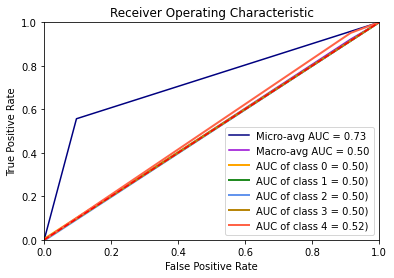

Loading training set at expr_data/para_editdist/10/r4/expr_para_editdist_n10_r4_amazon_reviews_digital_music.json


Running amazon experiment on para_editdist, N10, run# 4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


max_iter reached after 1 seconds
              precision    recall  f1-score   support

           1      0.000     0.000     0.000       220
           2      0.000     0.000     0.000       201
           3      0.111     0.002     0.003       604
           4      0.264     0.076     0.119      1662
           5      0.589     0.929     0.721      3783

    accuracy                          0.563      6470
   macro avg      0.193     0.201     0.169      6470
weighted avg      0.423     0.563     0.452      6470


Test set
AUC: 0 {'macro': 0.5013983861612464, 'micro': 0.7237442040185472, 0: 0.49976, 1: 0.49904290955495295, 2: 0.5001459188995738, 3: 0.5, 4: 0.5080431023517055}
Accuracy: 54.3122%


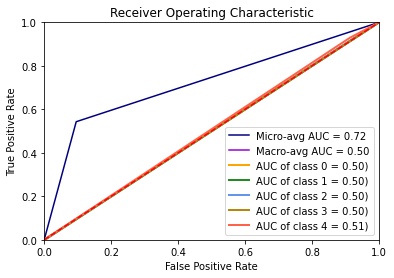

Loading training set at expr_data/para_editdist/10/r5/expr_para_editdist_n10_r5_amazon_reviews_digital_music.json


Running amazon experiment on para_editdist, N10, run# 5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

max_iter reached after 1 seconds
              precision    recall  f1-score   support

           1      0.500     0.005     0.009       220
           2      0.000     0.000     0.000       201
           3      0.000     0.000     0.000       604
           4      0.237     0.005     0.011      1662
           5      0.585     0.995     0.737      3783

    accuracy                          0.583      6470
   macro avg      0.264     0.201     0.151      6470
weighted avg      0.420     0.583     0.434      6470


Test set
AUC: 0 {'macro': 0.5006967184767009, 'micro': 0.7393353941267388, 0: 0.5021927272727273, 1: 0.4998404849258255, 2: 0.5, 3: 0.5, 4: 0.5014503801849518}
Accuracy: 58.1762%


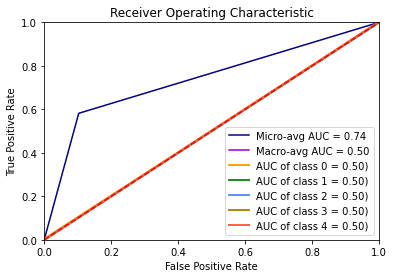

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/

Loading training set at expr_data/para_editdist/10/r6/expr_para_editdist_n10_r6_amazon_reviews_digital_music.json


Running amazon experiment on para_editdist, N10, run# 6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


max_iter reached after 1 seconds
              precision    recall  f1-score   support

           1      0.000     0.000     0.000       220
           2      0.143     0.005     0.010       201
           3      0.125     0.002     0.003       604
           4      0.262     0.075     0.117      1662
           5      0.593     0.936     0.726      3783

    accuracy                          0.567      6470
   macro avg      0.225     0.204     0.171      6470
weighted avg      0.430     0.567     0.455      6470


Test set
AUC: 0 {'macro': 0.5034611344727805, 'micro': 0.726564914992272, 0: 0.49984, 1: 0.5020090169665312, 2: 0.5002311558583192, 3: 0.5, 4: 0.515225499539052}
Accuracy: 54.7759%


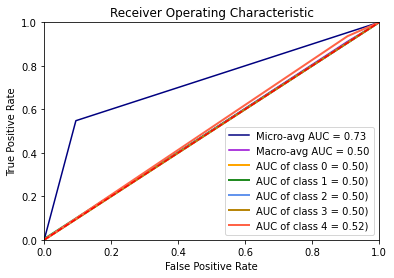

Loading training set at expr_data/para_editdist/10/r7/expr_para_editdist_n10_r7_amazon_reviews_digital_music.json


Running amazon experiment on para_editdist, N10, run# 7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

max_iter reached after 1 seconds
              precision    recall  f1-score   support

           1      0.000     0.000     0.000       220
           2      0.167     0.005     0.010       201
           3      0.000     0.000     0.000       604
           4      0.310     0.070     0.115      1662
           5      0.591     0.950     0.729      3783

    accuracy                          0.574      6470
   macro avg      0.214     0.205     0.171      6470
weighted avg      0.430     0.574     0.456      6470


Test set
AUC: 0 {'macro': 0.5027658246819688, 'micro': 0.7296561051004636, 0: 0.5, 1: 0.5020887745036186, 2: 0.49974428912376406, 3: 0.5, 4: 0.5119960597824617}
Accuracy: 55.5796%


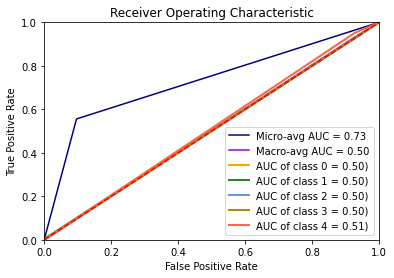

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/

Loading training set at expr_data/para_editdist/10/r8/expr_para_editdist_n10_r8_amazon_reviews_digital_music.json


Running amazon experiment on para_editdist, N10, run# 8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


max_iter reached after 1 seconds
              precision    recall  f1-score   support

           1      0.058     0.041     0.048       220
           2      0.000     0.000     0.000       201
           3      0.000     0.000     0.000       604
           4      0.292     0.025     0.047      1662
           5      0.585     0.950     0.724      3783

    accuracy                          0.563      6470
   macro avg      0.187     0.203     0.164      6470
weighted avg      0.419     0.563     0.437      6470


Test set
AUC: 0 {'macro': 0.5013824215500172, 'micro': 0.7256375579598145, 0: 0.5088545454545456, 1: 0.49760727388738235, 2: 0.49982952608250936, 3: 0.5, 4: 0.5006207623256491}
Accuracy: 55.6569%


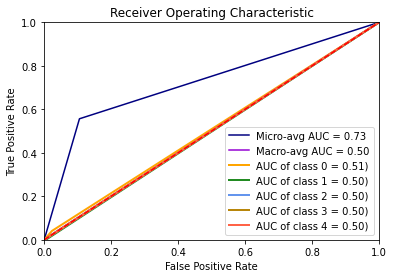

Loading training set at expr_data/para_editdist/10/r9/expr_para_editdist_n10_r9_amazon_reviews_digital_music.json


Running amazon experiment on para_editdist, N10, run# 9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.083     0.005     0.009       220
           2      1.000     0.005     0.010       201
           3      0.095     0.026     0.041       604
           4      0.341     0.109     0.165      1662
           5      0.609     0.927     0.735      3783

    accuracy                          0.573      6470
   macro avg      0.426     0.214     0.192      6470
weighted avg      0.486     0.573     0.477      6470


Test set
AUC: 0 {'macro': 0.509720857199445, 'micro': 0.7256761978361669, 0: 0.5013927272727273, 1: 0.5024875621890548, 2: 0.50020377842455, 3: 0.5, 4: 0.5445202181108934}
Accuracy: 54.4668%


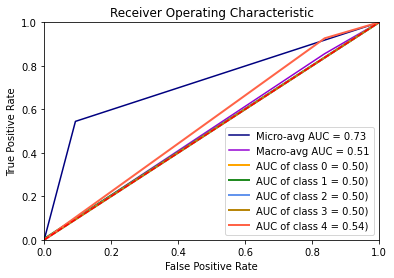

Loading training set at expr_data/para_editdist/10/r10/expr_para_editdist_n10_r10_amazon_reviews_digital_music.json


Running amazon experiment on para_editdist, N10, run# 10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.000     0.000     0.000       220
           2      0.000     0.000     0.000       201
           3      0.082     0.025     0.038       604
           4      0.316     0.282     0.298      1662
           5      0.617     0.778     0.688      3783

    accuracy                          0.530      6470
   macro avg      0.203     0.217     0.205      6470
weighted avg      0.449     0.530     0.482      6470


Test set
AUC: 0 {'macro': 0.5088023857453137, 'micro': 0.6893353941267388, 0: 0.4988, 1: 0.49888339448077845, 2: 0.4980121725150886, 3: 0.5, 4: 0.5483163617307011}
Accuracy: 45.7032%


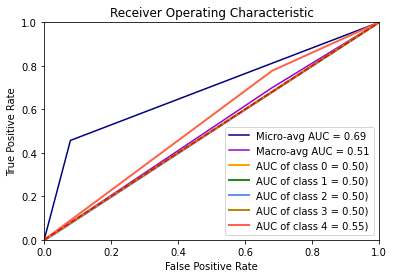

Loading training set at expr_data/para_editdist/10/r11/expr_para_editdist_n10_r11_amazon_reviews_digital_music.json


Running amazon experiment on para_editdist, N10, run# 11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.222     0.009     0.017       220
           2      0.083     0.020     0.032       201
           3      0.119     0.020     0.034       604
           4      0.333     0.224     0.268      1662
           5      0.622     0.854     0.719      3783

    accuracy                          0.559      6470
   macro avg      0.276     0.225     0.214      6470
weighted avg      0.470     0.559     0.494      6470


Test set
AUC: 0 {'macro': 0.5147432485120721, 'micro': 0.7102395672333849, 0: 0.5039854545454545, 1: 0.5064409171243797, 2: 0.5023476855061043, 3: 0.5, 4: 0.5609421853844216}
Accuracy: 50.1855%


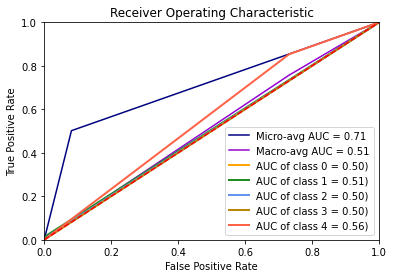

Loading training set at expr_data/para_tc_editdist/10/r0/expr_para_tc_editdist_n10_r0_amazon_reviews_digital_music.json


Running amazon experiment on para_tc_editdist, N10, run# 0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.273     0.014     0.026       220
           2      0.000     0.000     0.000       201
           3      0.000     0.000     0.000       604
           4      0.290     0.245     0.265      1662
           5      0.602     0.803     0.688      3783

    accuracy                          0.533      6470
   macro avg      0.233     0.212     0.196      6470
weighted avg      0.436     0.533     0.471      6470


Test set
AUC: 0 {'macro': 0.506533553646205, 'micro': 0.6956916537867079, 0: 0.5061781818181819, 1: 0.4998404849258255, 2: 0.49940334128878283, 3: 0.5, 4: 0.5272457601982348}
Accuracy: 46.9706%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


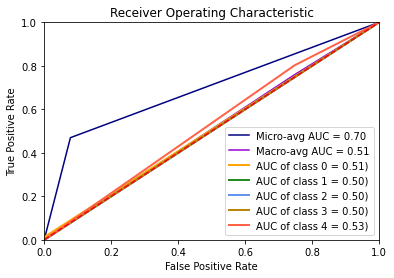

Loading training set at expr_data/para_tc_editdist/10/r1/expr_para_tc_editdist_n10_r1_amazon_reviews_digital_music.json


Running amazon experiment on para_tc_editdist, N10, run# 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
              precision    recall  f1-score   support

           1      0.000     0.000     0.000       220
           2      0.000     0.000     0.000       201
           3      0.000     0.000     0.000       604
           4      0.282     0.295     0.288      1662
           5      0.619     0.769     0.686      3783

    accuracy                          0.526      6470
   macro avg      0.180     0.213     0.195      6470
weighted avg      0.434     0.526     0.475      6470


Test set
AUC: 0 {'macro': 0.5097919581475152, 'micro': 0.6897797527047913, 0: 0.49968, 1: 0.4982453341840804, 2: 0.49974428912376406, 3: 0.5, 4: 0.5512901674297321}
Accuracy: 44.9923%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished


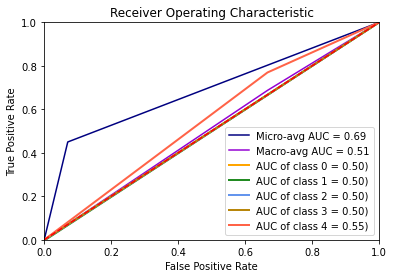

Loading training set at expr_data/para_tc_editdist/10/r2/expr_para_tc_editdist_n10_r2_amazon_reviews_digital_music.json


Running amazon experiment on para_tc_editdist, N10, run# 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.200     0.005     0.009       220
           2      0.000     0.000     0.000       201
           3      0.000     0.000     0.000       604
           4      0.331     0.321     0.326      1662
           5      0.640     0.817     0.718      3783

    accuracy                          0.560      6470
   macro avg      0.234     0.229     0.211      6470
weighted avg      0.466     0.560     0.504      6470


Test set
AUC: 0 {'macro': 0.5169867783589767, 'micro': 0.7047333848531685, 0: 0.5019527272727273, 1: 0.4983250917211676, 2: 0.49965905216501877, 3: 0.5, 4: 0.5849970206359696}
Accuracy: 47.7743%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


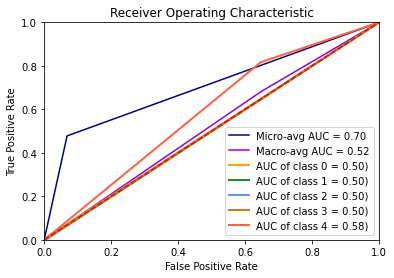

Loading training set at expr_data/para_tc_editdist/10/r3/expr_para_tc_editdist_n10_r3_amazon_reviews_digital_music.json


Running amazon experiment on para_tc_editdist, N10, run# 3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
              precision    recall  f1-score   support

           1      0.250     0.005     0.009       220
           2      0.000     0.000     0.000       201
           3      0.032     0.002     0.003       604
           4      0.321     0.090     0.140      1662
           5      0.595     0.938     0.728      3783

    accuracy                          0.572      6470
   macro avg      0.240     0.207     0.176      6470
weighted avg      0.442     0.572     0.462      6470


Test set
AUC: 0 {'macro': 0.5037375634516997, 'micro': 0.7268933539412674, 0: 0.5020327272727273, 1: 0.4997607273887382, 2: 0.49827070580717703, 3: 0.5, 4: 0.518623656789856}
Accuracy: 54.8686%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


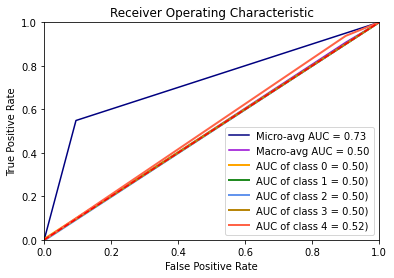

Loading training set at expr_data/para_tc_editdist/10/r4/expr_para_tc_editdist_n10_r4_amazon_reviews_digital_music.json


Running amazon experiment on para_tc_editdist, N10, run# 4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
              precision    recall  f1-score   support

           1      0.235     0.018     0.034       220
           2      0.031     0.005     0.009       201
           3      0.098     0.033     0.050       604
           4      0.259     0.140     0.182      1662
           5      0.596     0.838     0.697      3783

    accuracy                          0.530      6470
   macro avg      0.244     0.207     0.194      6470
weighted avg      0.433     0.530     0.460      6470


Test set
AUC: 0 {'macro': 0.5056059946148888, 'micro': 0.7009853168469862, 0: 0.508050909090909, 1: 0.5000150785393499, 2: 0.500872690981591, 3: 0.5, 4: 0.5190912944625935}
Accuracy: 49.3818%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


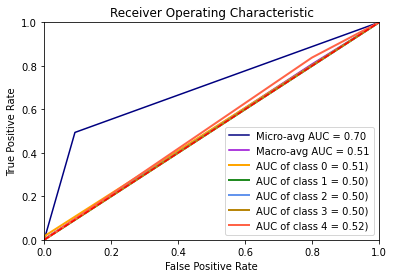

Loading training set at expr_data/para_tc_editdist/10/r5/expr_para_tc_editdist_n10_r5_amazon_reviews_digital_music.json


Running amazon experiment on para_tc_editdist, N10, run# 5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.286     0.009     0.018       220
           2      0.500     0.005     0.010       201
           3      0.000     0.000     0.000       604
           4      0.295     0.019     0.035      1662
           5      0.587     0.986     0.736      3783

    accuracy                          0.582      6470
   macro avg      0.334     0.204     0.160      6470
weighted avg      0.444     0.582     0.440      6470


Test set
AUC: 0 {'macro': 0.502116186875123, 'micro': 0.7375386398763525, 0: 0.5041454545454545, 1: 0.5024078046519675, 2: 0.5, 3: 0.5, 4: 0.5040276751781938}
Accuracy: 57.6816%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/

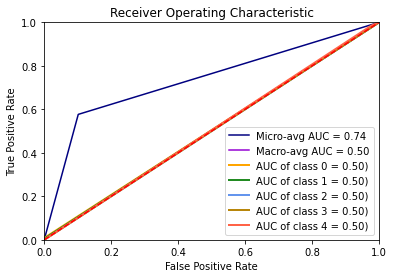

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/

Loading training set at expr_data/para_tc_editdist/10/r6/expr_para_tc_editdist_n10_r6_amazon_reviews_digital_music.json


Running amazon experiment on para_tc_editdist, N10, run# 6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.083     0.005     0.009       220
           2      0.125     0.010     0.018       201
           3      0.241     0.022     0.040       604
           4      0.295     0.153     0.201      1662
           5      0.596     0.870     0.707      3783

    accuracy                          0.551      6470
   macro avg      0.268     0.212     0.195      6470
weighted avg      0.453     0.551     0.470      6470


Test set
AUC: 0 {'macro': 0.5064098914920494, 'micro': 0.7112828438948995, 0: 0.5013927272727273, 1: 0.5038585188588879, 2: 0.5072668740954158, 3: 0.5, 4: 0.5195313372332161}
Accuracy: 51.1437%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


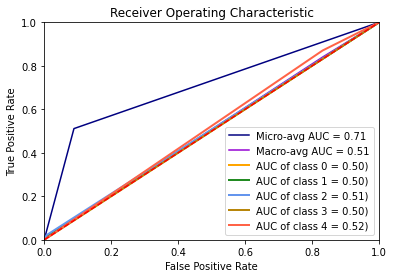

Loading training set at expr_data/para_tc_editdist/10/r7/expr_para_tc_editdist_n10_r7_amazon_reviews_digital_music.json


Running amazon experiment on para_tc_editdist, N10, run# 7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
              precision    recall  f1-score   support

           1      0.096     0.023     0.037       220
           2      0.000     0.000     0.000       201
           3      0.211     0.007     0.013       604
           4      0.301     0.039     0.069      1662
           5      0.591     0.966     0.733      3783

    accuracy                          0.576      6470
   macro avg      0.240     0.207     0.170      6470
weighted avg      0.446     0.576     0.449      6470


Test set
AUC: 0 {'macro': 0.5044610900070575, 'micro': 0.7331143740340031, 0: 0.5076036363636364, 1: 0.5, 2: 0.502032703896966, 3: 0.5, 4: 0.5126691097746849}
Accuracy: 56.6306%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/

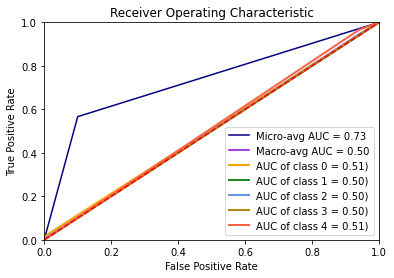

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/

Loading training set at expr_data/para_tc_editdist/10/r8/expr_para_tc_editdist_n10_r8_amazon_reviews_digital_music.json


Running amazon experiment on para_tc_editdist, N10, run# 8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.082     0.073     0.077       220
           2      0.050     0.030     0.037       201
           3      0.100     0.002     0.003       604
           4      0.305     0.155     0.205      1662
           5      0.595     0.834     0.695      3783

    accuracy                          0.531      6470
   macro avg      0.226     0.219     0.204      6470
weighted avg      0.440     0.531     0.463      6470


Test set
AUC: 0 {'macro': 0.5091897782999073, 'micro': 0.6983771251931994, 0: 0.5219636363636363, 1: 0.505753256369294, 2: 0.5000606819408285, 3: 0.5, 4: 0.5181713168257777}
Accuracy: 49.1345%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


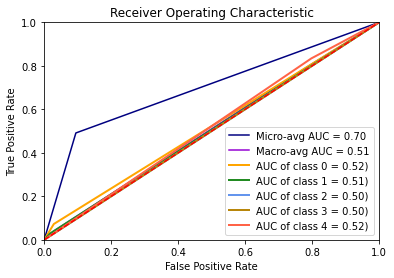

Loading training set at expr_data/para_tc_editdist/10/r9/expr_para_tc_editdist_n10_r9_amazon_reviews_digital_music.json


Running amazon experiment on para_tc_editdist, N10, run# 9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.500     0.005     0.009       220
           2      0.143     0.010     0.019       201
           3      0.149     0.048     0.073       604
           4      0.340     0.250     0.288      1662
           5      0.635     0.846     0.726      3783

    accuracy                          0.564      6470
   macro avg      0.354     0.232     0.223      6470
weighted avg      0.494     0.564     0.506      6470


Test set
AUC: 0 {'macro': 0.5194798340547159, 'micro': 0.7109157650695518, 0: 0.5021927272727273, 1: 0.5040180339330623, 2: 0.5099425243235798, 3: 0.5, 4: 0.58124588474421}
Accuracy: 49.9691%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


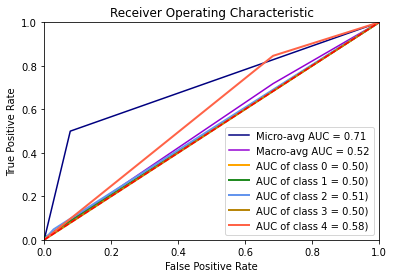

Loading training set at expr_data/para_tc_editdist/10/r10/expr_para_tc_editdist_n10_r10_amazon_reviews_digital_music.json


Running amazon experiment on para_tc_editdist, N10, run# 10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
              precision    recall  f1-score   support

           1      0.057     0.014     0.022       220
           2      0.000     0.000     0.000       201
           3      0.075     0.026     0.039       604
           4      0.301     0.302     0.301      1662
           5      0.618     0.738     0.673      3783

    accuracy                          0.512      6470
   macro avg      0.210     0.216     0.207      6470
weighted avg      0.448     0.512     0.475      6470


Test set
AUC: 0 {'macro': 0.5092324816713811, 'micro': 0.6789026275115919, 0: 0.5028181818181818, 1: 0.4986441218695167, 2: 0.4965385891985016, 3: 0.5, 4: 0.5481615154707056}
Accuracy: 43.4621%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


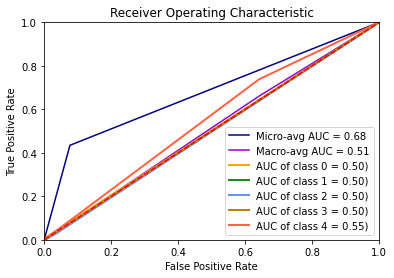

Loading training set at expr_data/para_tc_editdist/10/r11/expr_para_tc_editdist_n10_r11_amazon_reviews_digital_music.json


Running amazon experiment on para_tc_editdist, N10, run# 11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.114     0.018     0.031       220
           2      0.067     0.060     0.063       201
           3      0.078     0.026     0.040       604
           4      0.336     0.115     0.171      1662
           5      0.604     0.876     0.715      3783

    accuracy                          0.547      6470
   macro avg      0.240     0.219     0.204      6470
weighted avg      0.453     0.547     0.469      6470



/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished



Test set
AUC: 0 {'macro': 0.510893530503273, 'micro': 0.7090996908809891, 0: 0.506610909090909, 1: 0.5164514800379979, 2: 0.49713524790971875, 3: 0.5, 4: 0.5342700154777396}
Accuracy: 51.7002%


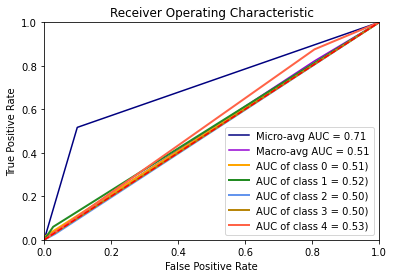

Loading training set at expr_data/tc/10/r0/expr_tc_n10_r0_amazon_reviews_digital_music.json


Running amazon experiment on tc, N10, run# 0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
              precision    recall  f1-score   support

           1      0.083     0.009     0.016       220
           2      0.000     0.000     0.000       201
           3      0.071     0.002     0.003       604
           4      0.297     0.229     0.259      1662
           5      0.602     0.819     0.694      3783

    accuracy                          0.538      6470
   macro avg      0.211     0.212     0.194      6470
weighted avg      0.438     0.538     0.473      6470


Test set
AUC: 0 {'macro': 0.5061005955194269, 'micro': 0.6992658423493046, 0: 0.5027854545454545, 1: 0.4997607273887382, 2: 0.49971973410584736, 3: 0.5, 4: 0.5282370615570942}
Accuracy: 47.9134%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


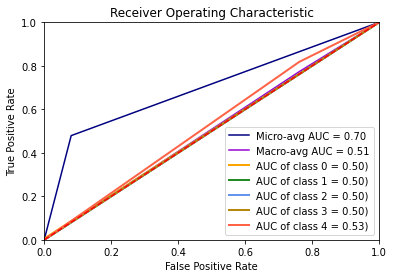

Loading training set at expr_data/tc/10/r1/expr_tc_n10_r1_amazon_reviews_digital_music.json


Running amazon experiment on tc, N10, run# 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.000     0.000     0.000       220
           2      0.059     0.005     0.009       201
           3      0.078     0.124     0.096       604
           4      0.262     0.267     0.265      1662
           5      0.595     0.596     0.596      3783

    accuracy                          0.429      6470
   macro avg      0.199     0.199     0.193      6470
weighted avg      0.424     0.429     0.425      6470


Test set
AUC: 0 {'macro': 0.49991146219006444, 'micro': 0.6329791344667697, 0: 0.49968, 1: 0.5012114415956587, 2: 0.48631043639064947, 3: 0.5, 4: 0.5123554329640142}
Accuracy: 36.0433%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


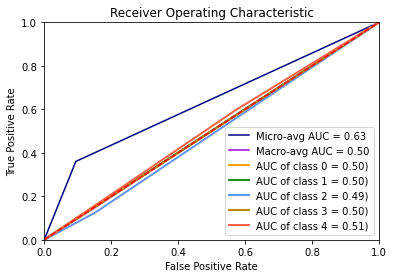

Loading training set at expr_data/tc/10/r2/expr_tc_n10_r2_amazon_reviews_digital_music.json


Running amazon experiment on tc, N10, run# 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.143     0.005     0.009       220
           2      0.000     0.000     0.000       201
           3      0.000     0.000     0.000       604
           4      0.332     0.171     0.226      1662
           5      0.611     0.901     0.728      3783

    accuracy                          0.571      6470
   macro avg      0.217     0.215     0.193      6470
weighted avg      0.447     0.571     0.484      6470


Test set
AUC: 0 {'macro': 0.5092629270969409, 'micro': 0.7210394126738795, 0: 0.5017927272727273, 1: 0.4982453341840804, 2: 0.49974428912376406, 3: 0.5, 4: 0.5465322849041325}
Accuracy: 52.7202%


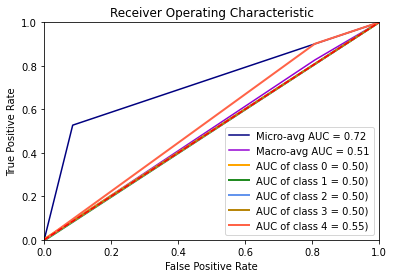

Loading training set at expr_data/tc/10/r3/expr_tc_n10_r3_amazon_reviews_digital_music.json


Running amazon experiment on tc, N10, run# 3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.000     0.000     0.000       220
           2      0.000     0.000     0.000       201
           3      0.067     0.002     0.003       604
           4      0.293     0.088     0.136      1662
           5      0.594     0.935     0.727      3783

    accuracy                          0.570      6470
   macro avg      0.191     0.205     0.173      6470
weighted avg      0.429     0.570     0.460      6470


Test set
AUC: 0 {'macro': 0.5035575638240657, 'micro': 0.7264489953632148, 0: 0.5, 1: 0.499680969851651, 2: 0.499634497147102, 3: 0.5, 4: 0.5184723521215758}
Accuracy: 54.6832%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


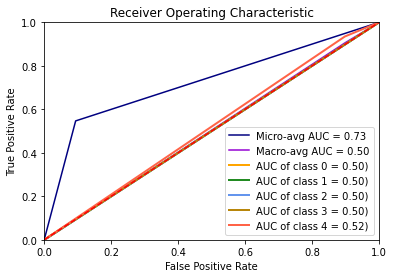

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/

Loading training set at expr_data/tc/10/r4/expr_tc_n10_r4_amazon_reviews_digital_music.json


Running amazon experiment on tc, N10, run# 4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.667     0.009     0.018       220
           2      0.000     0.000     0.000       201
           3      0.110     0.018     0.031       604
           4      0.249     0.200     0.222      1662
           5      0.584     0.774     0.666      3783

    accuracy                          0.506      6470
   macro avg      0.322     0.200     0.187      6470
weighted avg      0.438     0.506     0.450      6470


Test set
AUC: 0 {'macro': 0.5005852518807712, 'micro': 0.6849304482225658, 0: 0.5044654545454544, 1: 0.4987238794066039, 2: 0.5015198709365678, 3: 0.5, 4: 0.49821705451522935}
Accuracy: 45.4714%


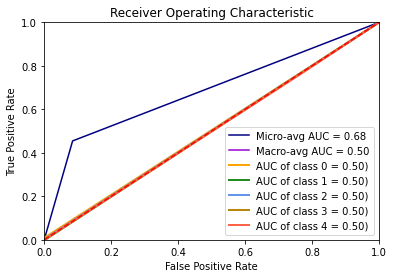

Loading training set at expr_data/tc/10/r5/expr_tc_n10_r5_amazon_reviews_digital_music.json


Running amazon experiment on tc, N10, run# 5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.286     0.009     0.018       220
           2      0.000     0.000     0.000       201
           3      0.000     0.000     0.000       604
           4      0.312     0.045     0.079      1662
           5      0.591     0.971     0.735      3783

    accuracy                          0.580      6470
   macro avg      0.238     0.205     0.166      6470
weighted avg      0.436     0.580     0.450      6470


Test set
AUC: 0 {'macro': 0.5031878947151267, 'micro': 0.7346406491499227, 0: 0.5041454545454545, 1: 0.49952145477747645, 2: 0.49982952608250936, 3: 0.5, 4: 0.5124430381701934}
Accuracy: 56.8006%


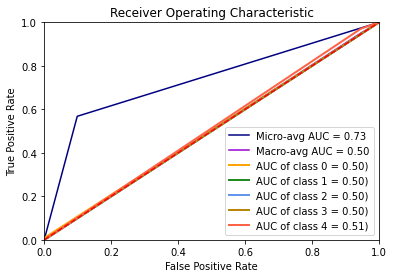

Loading training set at expr_data/tc/10/r6/expr_tc_n10_r6_amazon_reviews_digital_music.json


Running amazon experiment on tc, N10, run# 6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.000     0.000     0.000       220
           2      0.111     0.005     0.010       201
           3      0.214     0.005     0.010       604
           4      0.288     0.094     0.142      1662
           5      0.587     0.916     0.715      3783

    accuracy                          0.560      6470
   macro avg      0.240     0.204     0.175      6470
weighted avg      0.441     0.560     0.456      6470


Test set
AUC: 0 {'macro': 0.5013857984647382, 'micro': 0.7204598145285936, 0: 0.49992, 1: 0.5018495018923568, 2: 0.5015458371624109, 3: 0.5, 4: 0.5036136532689236}
Accuracy: 53.6012%


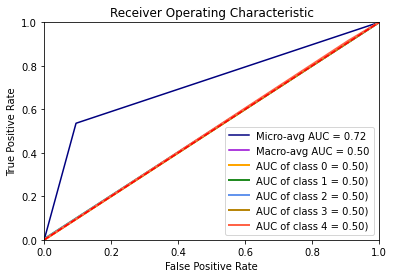

Loading training set at expr_data/tc/10/r7/expr_tc_n10_r7_amazon_reviews_digital_music.json


Running amazon experiment on tc, N10, run# 7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


max_iter reached after 1 seconds
              precision    recall  f1-score   support

           1      0.000     0.000     0.000       220
           2      0.160     0.020     0.035       201
           3      0.000     0.000     0.000       604
           4      0.284     0.051     0.087      1662
           5      0.590     0.957     0.730      3783

    accuracy                          0.573      6470
   macro avg      0.207     0.206     0.170      6470
weighted avg      0.423     0.573     0.450      6470


Test set
AUC: 0 {'macro': 0.5035895818016678, 'micro': 0.730757341576507, 0: 0.49904, 1: 0.5082753404773864, 2: 0.49974428912376406, 3: 0.5, 4: 0.5108882794071887}
Accuracy: 55.9969%


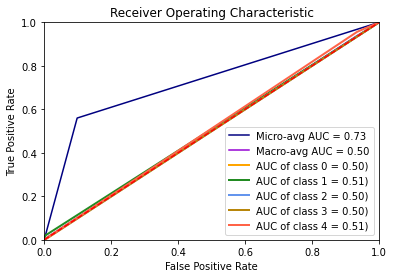

Loading training set at expr_data/tc/10/r8/expr_tc_n10_r8_amazon_reviews_digital_music.json


Running amazon experiment on tc, N10, run# 8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
              precision    recall  f1-score   support

           1      0.077     0.105     0.089       220
           2      0.018     0.005     0.008       201
           3      0.000     0.000     0.000       604
           4      0.305     0.073     0.118      1662
           5      0.590     0.891     0.710      3783

    accuracy                          0.543      6470
   macro avg      0.198     0.215     0.185      6470
weighted avg      0.427     0.543     0.449      6470


Test set
AUC: 0 {'macro': 0.5075661144413145, 'micro': 0.7104907264296755, 0: 0.5303527272727273, 1: 0.4980211401121685, 2: 0.4992328673712922, 3: 0.5, 4: 0.5102238374503845}
Accuracy: 52.4420%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


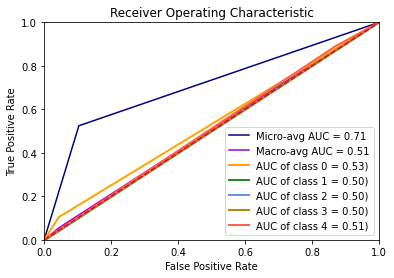

Loading training set at expr_data/tc/10/r9/expr_tc_n10_r9_amazon_reviews_digital_music.json


Running amazon experiment on tc, N10, run# 9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.333     0.005     0.009       220
           2      1.000     0.010     0.020       201
           3      0.108     0.023     0.038       604
           4      0.338     0.326     0.332      1662
           5      0.645     0.808     0.717      3783

    accuracy                          0.558      6470
   macro avg      0.485     0.234     0.223      6470
weighted avg      0.517     0.558     0.509      6470


Test set
AUC: 0 {'macro': 0.5200279235125356, 'micro': 0.7026854714064915, 0: 0.5021127272727273, 1: 0.5049751243781094, 2: 0.5017019167590537, 3: 0.5, 4: 0.5913498491527873}
Accuracy: 47.4807%


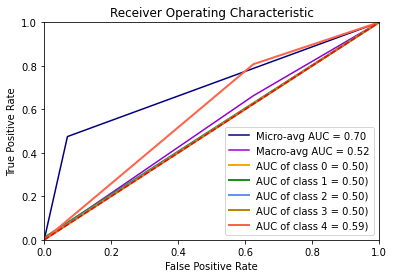

Loading training set at expr_data/tc/10/r10/expr_tc_n10_r10_amazon_reviews_digital_music.json


Running amazon experiment on tc, N10, run# 10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.071     0.009     0.016       220
           2      0.000     0.000     0.000       201
           3      0.062     0.022     0.032       604
           4      0.304     0.335     0.319      1662
           5      0.625     0.725     0.671      3783

    accuracy                          0.512      6470
   macro avg      0.212     0.218     0.208      6470
weighted avg      0.451     0.512     0.478      6470


Test set
AUC: 0 {'macro': 0.5103103725579191, 'micro': 0.676758114374034, 0: 0.5024654545454544, 1: 0.4992821821662147, 2: 0.4940551454898924, 3: 0.5, 4: 0.5557490805880341}
Accuracy: 42.6121%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


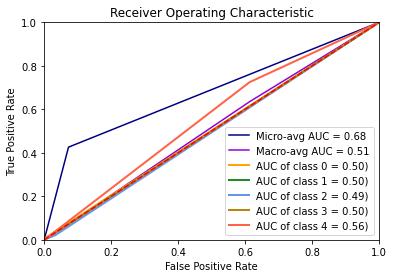

Loading training set at expr_data/tc/10/r11/expr_tc_n10_r11_amazon_reviews_digital_music.json


Running amazon experiment on tc, N10, run# 11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.109     0.027     0.044       220
           2      0.052     0.025     0.034       201
           3      0.091     0.055     0.068       604
           4      0.321     0.170     0.222      1662
           5      0.610     0.817     0.698      3783

    accuracy                          0.528      6470
   macro avg      0.236     0.219     0.213      6470
weighted avg      0.453     0.528     0.474      6470


Test set
AUC: 0 {'macro': 0.5108301311867551, 'micro': 0.6949768160741886, 0: 0.5097163636363636, 1: 0.5051001175332462, 2: 0.4991044474500037, 3: 0.5, 4: 0.5402297273141621}
Accuracy: 48.4699%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


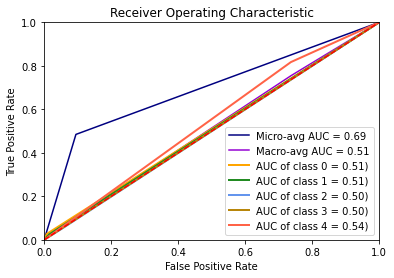

Loading training set at expr_data/tc_editdist/10/r0/expr_tc_editdist_n10_r0_amazon_reviews_digital_music.json


Running amazon experiment on tc_editdist, N10, run# 0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.056     0.005     0.008       220
           2      0.000     0.000     0.000       201
           3      0.000     0.000     0.000       604
           4      0.299     0.271     0.284      1662
           5      0.601     0.784     0.681      3783

    accuracy                          0.528      6470
   macro avg      0.191     0.212     0.195      6470
weighted avg      0.430     0.528     0.471      6470


Test set
AUC: 0 {'macro': 0.5051760912282444, 'micro': 0.690629829984544, 0: 0.5009127272727273, 1: 0.4998404849258255, 2: 0.49889191953631096, 3: 0.5, 4: 0.5262353244063578}
Accuracy: 45.8423%


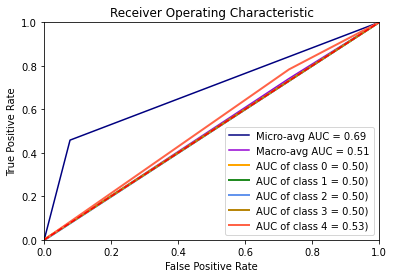

Loading training set at expr_data/tc_editdist/10/r1/expr_tc_editdist_n10_r1_amazon_reviews_digital_music.json


Running amazon experiment on tc_editdist, N10, run# 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.000     0.000     0.000       220
           2      0.000     0.000     0.000       201
           3      0.000     0.000     0.000       604
           4      0.251     0.239     0.245      1662
           5      0.598     0.767     0.672      3783

    accuracy                          0.510      6470
   macro avg      0.170     0.201     0.183      6470
weighted avg      0.414     0.510     0.456      6470


Test set
AUC: 0 {'macro': 0.5036157895783903, 'micro': 0.6859350850077279, 0: 0.4996, 1: 0.4992821821662147, 2: 0.49812478690760315, 3: 0.5, 4: 0.5210719788181335}
Accuracy: 44.8532%


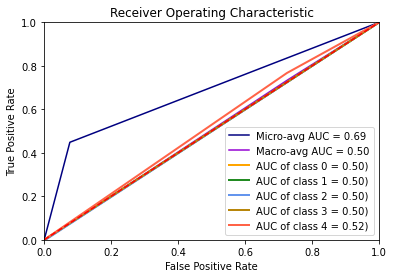

Loading training set at expr_data/tc_editdist/10/r2/expr_tc_editdist_n10_r2_amazon_reviews_digital_music.json


Running amazon experiment on tc_editdist, N10, run# 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


max_iter reached after 1 seconds
              precision    recall  f1-score   support

           1      0.143     0.005     0.009       220
           2      0.000     0.000     0.000       201
           3      0.000     0.000     0.000       604
           4      0.325     0.308     0.316      1662
           5      0.632     0.815     0.712      3783

    accuracy                          0.556      6470
   macro avg      0.220     0.225     0.207      6470
weighted avg      0.458     0.556     0.498      6470


Test set
AUC: 0 {'macro': 0.5148102777311333, 'micro': 0.703226429675425, 0: 0.5017927272727273, 1: 0.4992821821662147, 2: 0.49982952608250936, 3: 0.5, 4: 0.5731469531342153}
Accuracy: 47.6507%


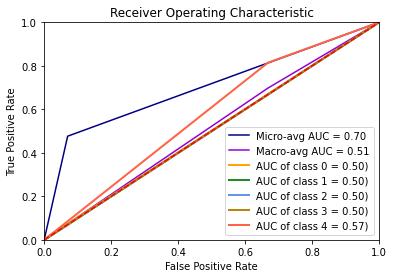

Loading training set at expr_data/tc_editdist/10/r3/expr_tc_editdist_n10_r3_amazon_reviews_digital_music.json


Running amazon experiment on tc_editdist, N10, run# 3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.000     0.000     0.000       220
           2      0.000     0.000     0.000       201
           3      0.071     0.007     0.012       604
           4      0.294     0.185     0.227      1662
           5      0.604     0.857     0.709      3783

    accuracy                          0.549      6470
   macro avg      0.194     0.210     0.190      6470
weighted avg      0.436     0.549     0.474      6470


Test set
AUC: 0 {'macro': 0.5065126182140349, 'micro': 0.7089064914992271, 0: 0.5, 1: 0.4999202424629127, 2: 0.4988789364233895, 3: 0.5, 4: 0.5337639121838723}
Accuracy: 50.1855%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/

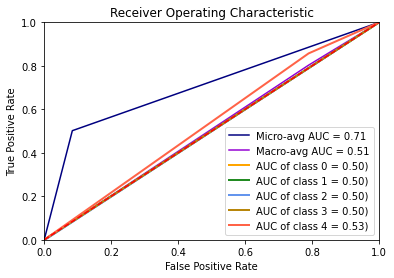

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/

Loading training set at expr_data/tc_editdist/10/r4/expr_tc_editdist_n10_r4_amazon_reviews_digital_music.json


Running amazon experiment on tc_editdist, N10, run# 4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.200     0.009     0.017       220
           2      0.000     0.000     0.000       201
           3      0.110     0.015     0.026       604
           4      0.268     0.175     0.212      1662
           5      0.593     0.828     0.691      3783

    accuracy                          0.531      6470
   macro avg      0.234     0.205     0.189      6470
weighted avg      0.432     0.531     0.461      6470


Test set
AUC: 0 {'macro': 0.5036808036836757, 'micro': 0.699710200927357, 0: 0.5039054545454545, 1: 0.4994416972403892, 2: 0.50122803313742, 3: 0.5, 4: 0.5138288334951152}
Accuracy: 48.5935%


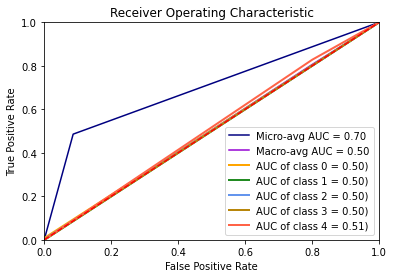

Loading training set at expr_data/tc_editdist/10/r5/expr_tc_editdist_n10_r5_amazon_reviews_digital_music.json


Running amazon experiment on tc_editdist, N10, run# 5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


max_iter reached after 1 seconds
              precision    recall  f1-score   support

           1      0.286     0.009     0.018       220
           2      0.000     0.000     0.000       201
           3      0.000     0.000     0.000       604
           4      0.262     0.026     0.047      1662
           5      0.588     0.979     0.735      3783

    accuracy                          0.579      6470
   macro avg      0.227     0.203     0.160      6470
weighted avg      0.421     0.579     0.442      6470


Test set
AUC: 0 {'macro': 0.5021850067269734, 'micro': 0.7360703245749615, 0: 0.5041454545454545, 1: 0.4997607273887382, 2: 0.4999147630412547, 3: 0.5, 4: 0.50710408865942}
Accuracy: 57.2643%


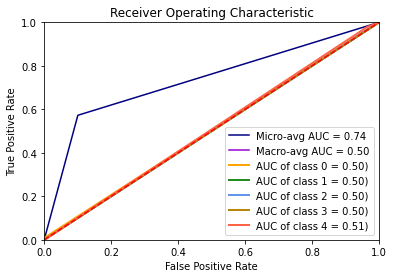

Loading training set at expr_data/tc_editdist/10/r6/expr_tc_editdist_n10_r6_amazon_reviews_digital_music.json


Running amazon experiment on tc_editdist, N10, run# 6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.000     0.000     0.000       220
           2      0.077     0.005     0.009       201
           3      0.200     0.008     0.016       604
           4      0.283     0.091     0.138      1662
           5      0.585     0.913     0.713      3783

    accuracy                          0.558      6470
   macro avg      0.229     0.203     0.175      6470
weighted avg      0.436     0.558     0.454      6470


Test set
AUC: 0 {'macro': 0.5010600523144642, 'micro': 0.719435857805255, 0: 0.49992, 1: 0.5015304717440077, 2: 0.5024343336727759, 3: 0.5, 4: 0.5014154561555373}
Accuracy: 53.4621%


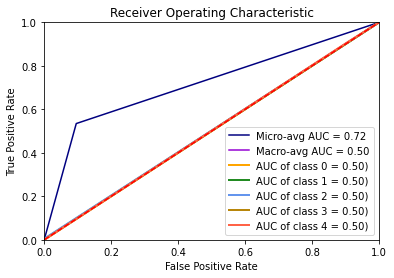

Loading training set at expr_data/tc_editdist/10/r7/expr_tc_editdist_n10_r7_amazon_reviews_digital_music.json


Running amazon experiment on tc_editdist, N10, run# 7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.500     0.005     0.009       220
           2      0.000     0.000     0.000       201
           3      0.000     0.000     0.000       604
           4      0.318     0.107     0.160      1662
           5      0.594     0.928     0.724      3783

    accuracy                          0.570      6470
   macro avg      0.283     0.208     0.179      6470
weighted avg      0.446     0.570     0.465      6470


Test set
AUC: 0 {'macro': 0.5039828532139999, 'micro': 0.7249613601236476, 0: 0.5021927272727273, 1: 0.4998404849258255, 2: 0.5, 3: 0.5, 4: 0.5178810538714467}
Accuracy: 54.2658%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


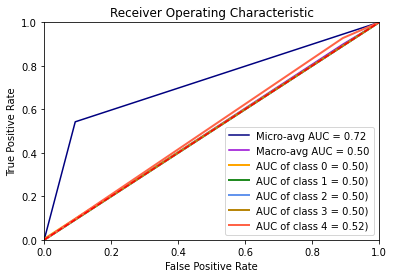

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/

Loading training set at expr_data/tc_editdist/10/r8/expr_tc_editdist_n10_r8_amazon_reviews_digital_music.json


Running amazon experiment on tc_editdist, N10, run# 8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.065     0.077     0.071       220
           2      0.000     0.000     0.000       201
           3      0.090     0.017     0.028       604
           4      0.329     0.032     0.058      1662
           5      0.590     0.918     0.718      3783

    accuracy                          0.549      6470
   macro avg      0.215     0.209     0.175      6470
weighted avg      0.440     0.549     0.440      6470


Test set
AUC: 0 {'macro': 0.504840195513969, 'micro': 0.716016228748068, 0: 0.5190363636363635, 1: 0.49593236560855003, 2: 0.4996692128620877, 3: 0.5, 4: 0.5095630354628432}
Accuracy: 54.0649%


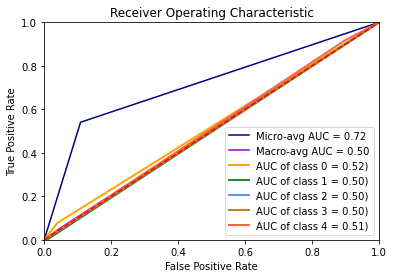

Loading training set at expr_data/tc_editdist/10/r9/expr_tc_editdist_n10_r9_amazon_reviews_digital_music.json


Running amazon experiment on tc_editdist, N10, run# 9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.333     0.005     0.009       220
           2      0.333     0.005     0.010       201
           3      0.105     0.036     0.054       604
           4      0.333     0.249     0.285      1662
           5      0.636     0.843     0.725      3783

    accuracy                          0.560      6470
   macro avg      0.348     0.228     0.217      6470
weighted avg      0.489     0.560     0.503      6470


Test set
AUC: 0 {'macro': 0.5177692382314104, 'micro': 0.7093122102009273, 0: 0.5021127272727273, 1: 0.5023280471148802, 2: 0.502272609244428, 3: 0.5, 4: 0.5821328075250167}
Accuracy: 49.6445%


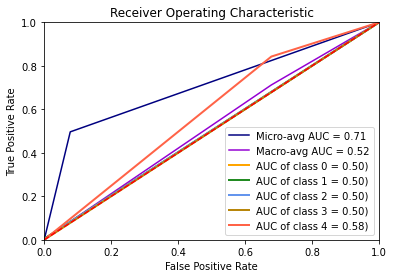

Loading training set at expr_data/tc_editdist/10/r10/expr_tc_editdist_n10_r10_amazon_reviews_digital_music.json


Running amazon experiment on tc_editdist, N10, run# 10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.063     0.027     0.038       220
           2      0.000     0.000     0.000       201
           3      0.075     0.041     0.053       604
           4      0.308     0.350     0.327      1662
           5      0.630     0.691     0.659      3783

    accuracy                          0.498      6470
   macro avg      0.215     0.222     0.216      6470
weighted avg      0.456     0.498     0.476      6470


Test set
AUC: 0 {'macro': 0.5120359842771562, 'micro': 0.6669049459041732, 0: 0.5065163636363637, 1: 0.499680969851651, 2: 0.4944423809448545, 3: 0.5, 4: 0.559540206952912}
Accuracy: 40.8655%


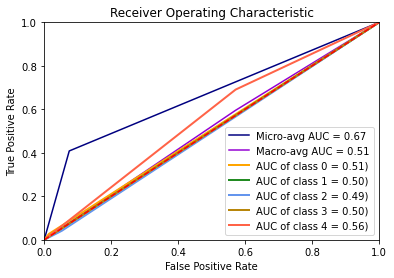

Loading training set at expr_data/tc_editdist/10/r11/expr_tc_editdist_n10_r11_amazon_reviews_digital_music.json


Running amazon experiment on tc_editdist, N10, run# 11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.138     0.018     0.032       220
           2      0.057     0.055     0.056       201
           3      0.132     0.079     0.099       604
           4      0.316     0.171     0.222      1662
           5      0.615     0.810     0.699      3783

    accuracy                          0.527      6470
   macro avg      0.251     0.227     0.222      6470
weighted avg      0.459     0.527     0.478      6470


Test set
AUC: 0 {'macro': 0.5160705025733935, 'micro': 0.6944358578052551, 0: 0.507090909090909, 1: 0.5127675547926345, 2: 0.5128002203742298, 3: 0.5, 4: 0.5476938286091944}
Accuracy: 48.3308%


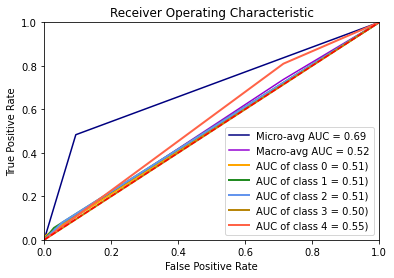

Loading training set at expr_data/eda/10/r0/expr_eda_n10_r0_amazon_reviews_digital_music.json


Running amazon experiment on eda, N10, run# 0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
              precision    recall  f1-score   support

           1      0.062     0.005     0.008       220
           2      0.000     0.000     0.000       201
           3      0.000     0.000     0.000       604
           4      0.292     0.326     0.308      1662
           5      0.607     0.737     0.665      3783

    accuracy                          0.515      6470
   macro avg      0.192     0.213     0.196      6470
weighted avg      0.432     0.515     0.468      6470


Test set
AUC: 0 {'macro': 0.5065182778539373, 'micro': 0.6801197836166923, 0: 0.5010727272727273, 1: 0.4999202424629127, 2: 0.4994885782475281, 3: 0.5, 4: 0.5321098412865186}
Accuracy: 43.0912%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


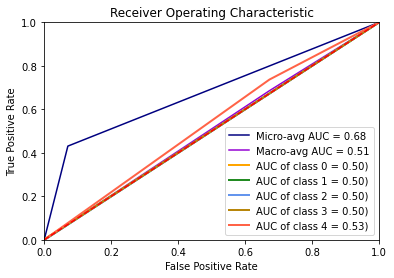

Loading training set at expr_data/eda/10/r1/expr_eda_n10_r1_amazon_reviews_digital_music.json


Running amazon experiment on eda, N10, run# 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.125     0.005     0.009       220
           2      0.000     0.000     0.000       201
           3      0.188     0.005     0.010       604
           4      0.274     0.205     0.235      1662
           5      0.611     0.841     0.708      3783

    accuracy                          0.545      6470
   macro avg      0.240     0.211     0.192      6470
weighted avg      0.450     0.545     0.475      6470


Test set
AUC: 0 {'macro': 0.5094319914148953, 'micro': 0.7065880989180834, 0: 0.5017127272727273, 1: 0.4998404849258255, 2: 0.5013753632449203, 3: 0.5, 4: 0.5442313816310034}
Accuracy: 49.2117%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


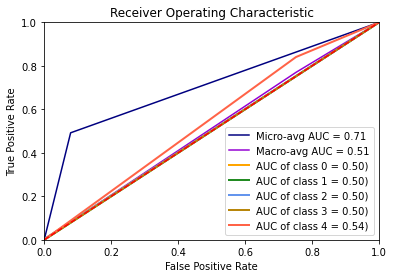

Loading training set at expr_data/eda/10/r2/expr_eda_n10_r2_amazon_reviews_digital_music.json


Running amazon experiment on eda, N10, run# 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.143     0.005     0.009       220
           2      0.000     0.000     0.000       201
           3      0.000     0.000     0.000       604
           4      0.318     0.276     0.295      1662
           5      0.629     0.833     0.717      3783

    accuracy                          0.558      6470
   macro avg      0.218     0.223     0.204      6470
weighted avg      0.454     0.558     0.495      6470


Test set
AUC: 0 {'macro': 0.5142775827756617, 'micro': 0.7074961360123648, 0: 0.5017927272727273, 1: 0.4996012123145637, 2: 0.49974428912376406, 3: 0.5, 4: 0.5702496851672532}
Accuracy: 48.7481%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


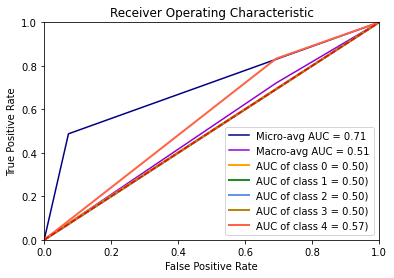

Loading training set at expr_data/eda/10/r3/expr_eda_n10_r3_amazon_reviews_digital_music.json


Running amazon experiment on eda, N10, run# 3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.000     0.000     0.000       220
           2      0.000     0.000     0.000       201
           3      0.076     0.010     0.018       604
           4      0.303     0.164     0.213      1662
           5      0.598     0.868     0.708      3783

    accuracy                          0.550      6470
   macro avg      0.195     0.208     0.188      6470
weighted avg      0.434     0.550     0.470      6470


Test set
AUC: 0 {'macro': 0.504326515237603, 'micro': 0.7100656877897991, 0: 0.49992, 1: 0.4999202424629127, 2: 0.4987445894288107, 3: 0.5, 4: 0.5230477442962911}
Accuracy: 50.8346%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


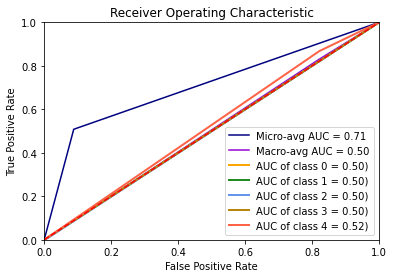

Loading training set at expr_data/eda/10/r4/expr_eda_n10_r4_amazon_reviews_digital_music.json


Running amazon experiment on eda, N10, run# 4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.222     0.009     0.017       220
           2      0.043     0.025     0.032       201
           3      0.083     0.012     0.020       604
           4      0.257     0.242     0.249      1662
           5      0.589     0.732     0.653      3783

    accuracy                          0.492      6470
   macro avg      0.239     0.204     0.194      6470
weighted avg      0.427     0.492     0.449      6470


Test set
AUC: 0 {'macro': 0.5027820543197481, 'micro': 0.6740533230293664, 0: 0.5039854545454545, 1: 0.5036644818656756, 2: 0.4992314561633659, 3: 0.5, 4: 0.5070288790242443}
Accuracy: 43.0139%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


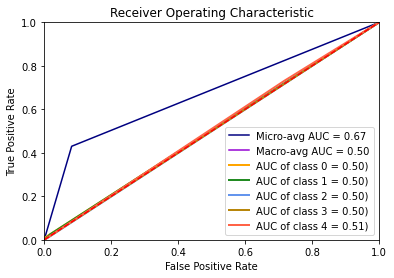

Loading training set at expr_data/eda/10/r5/expr_eda_n10_r5_amazon_reviews_digital_music.json


Running amazon experiment on eda, N10, run# 5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
              precision    recall  f1-score   support

           1      0.083     0.005     0.009       220
           2      0.000     0.000     0.000       201
           3      0.000     0.000     0.000       604
           4      0.292     0.019     0.035      1662
           5      0.587     0.986     0.736      3783

    accuracy                          0.581      6470
   macro avg      0.193     0.202     0.156      6470
weighted avg      0.421     0.581     0.440      6470


Test set
AUC: 0 {'macro': 0.5013178603874674, 'micro': 0.7374613601236476, 0: 0.5013927272727273, 1: 0.4999202424629127, 2: 0.5, 3: 0.5, 4: 0.5052763322016964}
Accuracy: 57.6662%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/

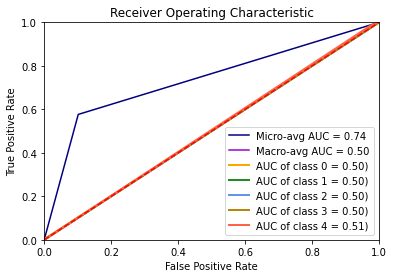

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/

Loading training set at expr_data/eda/10/r6/expr_eda_n10_r6_amazon_reviews_digital_music.json


Running amazon experiment on eda, N10, run# 6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.000     0.000     0.000       220
           2      0.125     0.005     0.010       201
           3      0.333     0.002     0.003       604
           4      0.302     0.186     0.230      1662
           5      0.602     0.865     0.710      3783

    accuracy                          0.554      6470
   macro avg      0.273     0.212     0.191      6470
weighted avg      0.465     0.554     0.475      6470


Test set
AUC: 0 {'macro': 0.506500042361115, 'micro': 0.7111089644513137, 0: 0.5, 1: 0.501929259429444, 2: 0.5006573406520457, 3: 0.5, 4: 0.5299136117240852}
Accuracy: 50.6182%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/

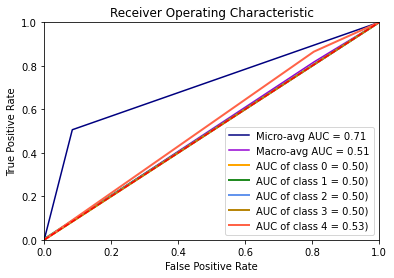

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/

Loading training set at expr_data/eda/10/r7/expr_eda_n10_r7_amazon_reviews_digital_music.json


Running amazon experiment on eda, N10, run# 7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.143     0.014     0.025       220
           2      0.000     0.000     0.000       201
           3      0.000     0.000     0.000       604
           4      0.303     0.058     0.098      1662
           5      0.589     0.954     0.728      3783

    accuracy                          0.573      6470
   macro avg      0.207     0.205     0.170      6470
weighted avg      0.427     0.573     0.452      6470


Test set
AUC: 0 {'macro': 0.5026488364098808, 'micro': 0.7300038639876352, 0: 0.5053781818181818, 1: 0.4999202424629127, 2: 0.5, 3: 0.5, 4: 0.5079457577683093}
Accuracy: 55.8114%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/

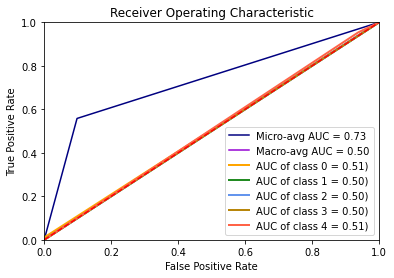

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/

Loading training set at expr_data/eda/10/r8/expr_eda_n10_r8_amazon_reviews_digital_music.json


Running amazon experiment on eda, N10, run# 8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.073     0.041     0.052       220
           2      0.000     0.000     0.000       201
           3      0.500     0.002     0.003       604
           4      0.267     0.059     0.097      1662
           5      0.586     0.924     0.717      3783

    accuracy                          0.557      6470
   macro avg      0.285     0.205     0.174      6470
weighted avg      0.460     0.557     0.446      6470


Test set
AUC: 0 {'macro': 0.502670778191264, 'micro': 0.7207689335394127, 0: 0.5112545454545455, 1: 0.4992821821662147, 2: 0.5007425776107911, 3: 0.5, 4: 0.5020745857247686}
Accuracy: 54.1886%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


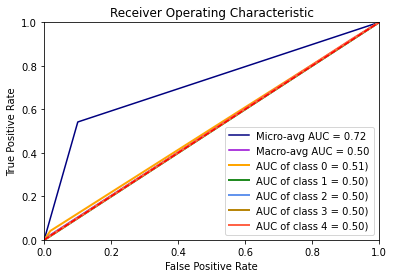

Loading training set at expr_data/eda/10/r9/expr_eda_n10_r9_amazon_reviews_digital_music.json


Running amazon experiment on eda, N10, run# 9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.083     0.005     0.009       220
           2      0.500     0.005     0.010       201
           3      0.129     0.018     0.032       604
           4      0.329     0.245     0.281      1662
           5      0.627     0.850     0.722      3783

    accuracy                          0.562      6470
   macro avg      0.334     0.225     0.211      6470
weighted avg      0.482     0.562     0.498      6470


Test set
AUC: 0 {'macro': 0.515089047500749, 'micro': 0.7109544049459042, 0: 0.5013927272727273, 1: 0.5024078046519675, 2: 0.5027984253177475, 3: 0.5, 4: 0.5688462802613026}
Accuracy: 49.9227%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


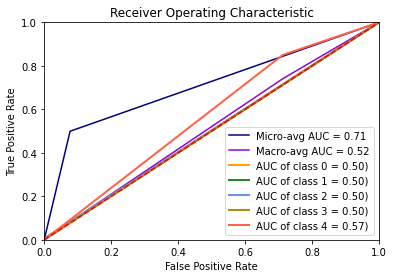

Loading training set at expr_data/eda/10/r10/expr_eda_n10_r10_amazon_reviews_digital_music.json


Running amazon experiment on eda, N10, run# 10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
              precision    recall  f1-score   support

           1      0.000     0.000     0.000       220
           2      0.000     0.000     0.000       201
           3      0.082     0.025     0.038       604
           4      0.312     0.484     0.380      1662
           5      0.647     0.631     0.639      3783

    accuracy                          0.496      6470
   macro avg      0.208     0.228     0.211      6470
weighted avg      0.466     0.496     0.475      6470


Test set
AUC: 0 {'macro': 0.5139375555311143, 'micro': 0.6568778979907264, 0: 0.49824, 1: 0.4999202424629127, 2: 0.49818264643257926, 3: 0.5, 4: 0.5733448887600799}
Accuracy: 37.1406%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


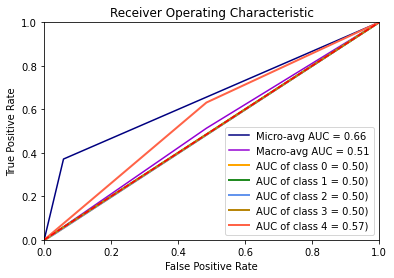

Loading training set at expr_data/eda/10/r11/expr_eda_n10_r11_amazon_reviews_digital_music.json


Running amazon experiment on eda, N10, run# 11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
              precision    recall  f1-score   support

           1      0.217     0.023     0.041       220
           2      0.100     0.005     0.009       201
           3      0.092     0.045     0.060       604
           4      0.349     0.152     0.211      1662
           5      0.609     0.873     0.718      3783

    accuracy                          0.554      6470
   macro avg      0.273     0.219     0.208      6470
weighted avg      0.465     0.554     0.481      6470


Test set
AUC: 0 {'macro': 0.5106812611139803, 'micro': 0.7111089644513138, 0: 0.5099236363636364, 1: 0.5017697443552694, 2: 0.49959272539248517, 3: 0.5, 4: 0.5421201994585103}
Accuracy: 51.5456%


/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


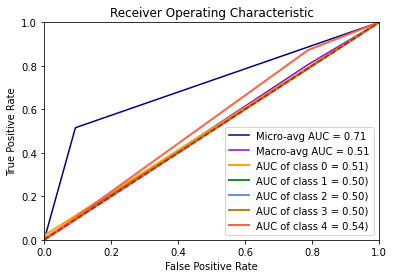

Loading training set at expr_data/bt/10/r0/expr_bt_n10_r0_amazon_reviews_digital_music.json


Running amazon experiment on bt, N10, run# 0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.100     0.005     0.009       220
           2      0.000     0.000     0.000       201
           3      0.125     0.002     0.003       604
           4      0.285     0.197     0.233      1662
           5      0.599     0.839     0.699      3783

    accuracy                          0.541      6470
   macro avg      0.222     0.208     0.189      6470
weighted avg      0.438     0.541     0.469      6470


Test set
AUC: 0 {'macro': 0.5050092886082584, 'micro': 0.7038833075734158, 0: 0.5015527272727274, 1: 0.499680969851651, 2: 0.5002311558583192, 3: 0.5, 4: 0.5235815900585946}
Accuracy: 49.0726%


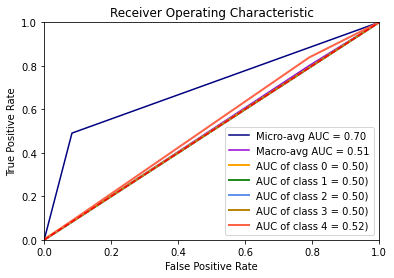

Loading training set at expr_data/bt/10/r1/expr_bt_n10_r1_amazon_reviews_digital_music.json


Running amazon experiment on bt, N10, run# 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

max_iter reached after 1 seconds
              precision    recall  f1-score   support

           1      0.000     0.000     0.000       220
           2      0.000     0.000     0.000       201
           3      0.167     0.007     0.013       604
           4      0.273     0.451     0.340      1662
           5      0.632     0.617     0.625      3783

    accuracy                          0.477      6470
   macro avg      0.214     0.215     0.195      6470
weighted avg      0.455     0.477     0.454      6470


Test set
AUC: 0 {'macro': 0.5114783846337698, 'micro': 0.6540765069551777, 0: 0.49968, 1: 0.5, 2: 0.5016065191032395, 3: 0.5, 4: 0.5561054040656096}
Accuracy: 36.1515%


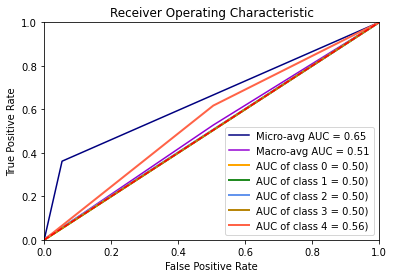

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/

Loading training set at expr_data/bt/10/r2/expr_bt_n10_r2_amazon_reviews_digital_music.json


Running amazon experiment on bt, N10, run# 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


max_iter reached after 1 seconds
              precision    recall  f1-score   support

           1      0.000     0.000     0.000       220
           2      0.000     0.000     0.000       201
           3      0.000     0.000     0.000       604
           4      0.323     0.238     0.274      1662
           5      0.623     0.862     0.723      3783

    accuracy                          0.565      6470
   macro avg      0.189     0.220     0.199      6470
weighted avg      0.447     0.565     0.493      6470


Test set
AUC: 0 {'macro': 0.5126057439581152, 'micro': 0.7136205564142194, 0: 0.49984, 1: 0.49952145477747645, 2: 0.49974428912376406, 3: 0.5, 4: 0.5639229758893355}
Accuracy: 50.3864%


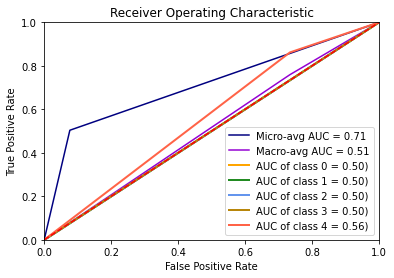

Loading training set at expr_data/bt/10/r3/expr_bt_n10_r3_amazon_reviews_digital_music.json


Running amazon experiment on bt, N10, run# 3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.000     0.000     0.000       220
           2      0.000     0.000     0.000       201
           3      0.058     0.015     0.024       604
           4      0.282     0.070     0.112      1662
           5      0.593     0.925     0.723      3783

    accuracy                          0.560      6470
   macro avg      0.187     0.202     0.172      6470
weighted avg      0.425     0.560     0.453      6470


Test set
AUC: 0 {'macro': 0.5020101166006699, 'micro': 0.7217156105100464, 0: 0.49976, 1: 0.4999202424629127, 2: 0.49500573514901225, 3: 0.5, 4: 0.5153646053914241}
Accuracy: 54.2040%


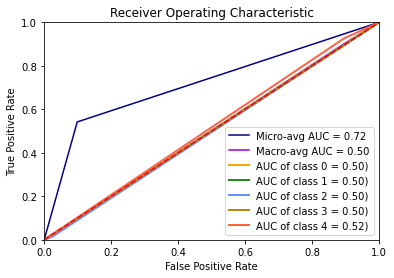

Loading training set at expr_data/bt/10/r4/expr_bt_n10_r4_amazon_reviews_digital_music.json


Running amazon experiment on bt, N10, run# 4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.067     0.005     0.009       220
           2      0.000     0.000     0.000       201
           3      0.087     0.013     0.023       604
           4      0.236     0.111     0.151      1662
           5      0.587     0.863     0.699      3783

    accuracy                          0.534      6470
   macro avg      0.195     0.198     0.176      6470
weighted avg      0.414     0.534     0.450      6470


Test set
AUC: 0 {'macro': 0.5006362998905244, 'micro': 0.7062210200927357, 0: 0.5011527272727273, 1: 0.4978465464986441, 2: 0.49946261202168524, 3: 0.5, 4: 0.5047196136595651}
Accuracy: 50.5873%


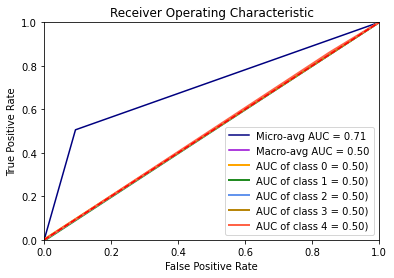

Loading training set at expr_data/bt/10/r5/expr_bt_n10_r5_amazon_reviews_digital_music.json


Running amazon experiment on bt, N10, run# 5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.143     0.005     0.009       220
           2      0.000     0.000     0.000       201
           3      0.000     0.000     0.000       604
           4      0.333     0.005     0.011      1662
           5      0.586     0.997     0.738      3783

    accuracy                          0.584      6470
   macro avg      0.212     0.201     0.151      6470
weighted avg      0.433     0.584     0.435      6470


Test set
AUC: 0 {'macro': 0.5008378771480122, 'micro': 0.7397990726429675, 0: 0.5017927272727273, 1: 0.4999202424629127, 2: 0.4999147630412547, 3: 0.5, 4: 0.5025616529631661}
Accuracy: 58.2844%


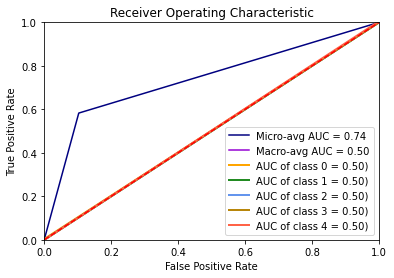

Loading training set at expr_data/bt/10/r6/expr_bt_n10_r6_amazon_reviews_digital_music.json


Running amazon experiment on bt, N10, run# 6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.250     0.005     0.009       220
           2      0.130     0.015     0.027       201
           3      0.000     0.000     0.000       604
           4      0.299     0.162     0.211      1662
           5      0.605     0.886     0.719      3783

    accuracy                          0.561      6470
   macro avg      0.257     0.214     0.193      6470
weighted avg      0.443     0.561     0.476      6470


Test set
AUC: 0 {'macro': 0.5087843092980628, 'micro': 0.7167117465224111, 0: 0.5020327272727273, 1: 0.5058675358254191, 2: 0.5, 3: 0.5, 4: 0.5360212833921679}
Accuracy: 51.8856%


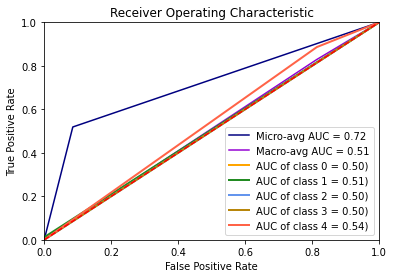

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/

Loading training set at expr_data/bt/10/r7/expr_bt_n10_r7_amazon_reviews_digital_music.json


Running amazon experiment on bt, N10, run# 7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.000     0.000     0.000       220
           2      0.222     0.010     0.019       201
           3      0.000     0.000     0.000       604
           4      0.309     0.054     0.091      1662
           5      0.590     0.962     0.732      3783

    accuracy                          0.577      6470
   macro avg      0.224     0.205     0.168      6470
weighted avg      0.431     0.577     0.452      6470


Test set
AUC: 0 {'macro': 0.5029364860058514, 'micro': 0.7323802163833075, 0: 0.49992, 1: 0.5044168216184987, 2: 0.49965905216501877, 3: 0.5, 4: 0.5106865562457397}
Accuracy: 56.2906%


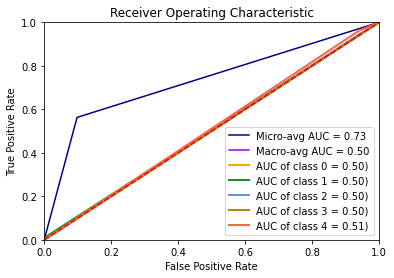

Loading training set at expr_data/bt/10/r8/expr_bt_n10_r8_amazon_reviews_digital_music.json


Running amazon experiment on bt, N10, run# 8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.072     0.086     0.079       220
           2      0.000     0.000     0.000       201
           3      0.000     0.000     0.000       604
           4      0.251     0.051     0.084      1662
           5      0.588     0.910     0.714      3783

    accuracy                          0.548      6470
   macro avg      0.182     0.209     0.175      6470
weighted avg      0.411     0.548     0.442      6470


Test set
AUC: 0 {'macro': 0.5055602947632692, 'micro': 0.7157843894899536, 0: 0.5236618181818182, 1: 0.4991226670920402, 2: 0.49965905216501877, 3: 0.5, 4: 0.5053579363774691}
Accuracy: 53.4930%


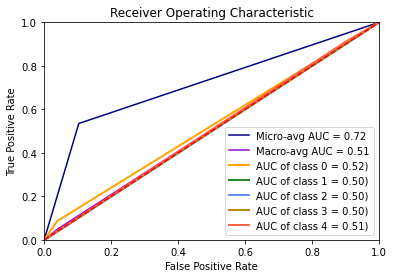

Loading training set at expr_data/bt/10/r9/expr_bt_n10_r9_amazon_reviews_digital_music.json


Running amazon experiment on bt, N10, run# 9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.222     0.009     0.017       220
           2      0.143     0.005     0.010       201
           3      0.109     0.036     0.055       604
           4      0.324     0.229     0.268      1662
           5      0.622     0.834     0.712      3783

    accuracy                          0.550      6470
   macro avg      0.284     0.223     0.212      6470
weighted avg      0.469     0.550     0.491      6470


Test set
AUC: 0 {'macro': 0.5136968430626264, 'micro': 0.7049265842349305, 0: 0.5039854545454545, 1: 0.5020090169665312, 2: 0.5029545049143905, 3: 0.5, 4: 0.5595352388867558}
Accuracy: 49.1499%


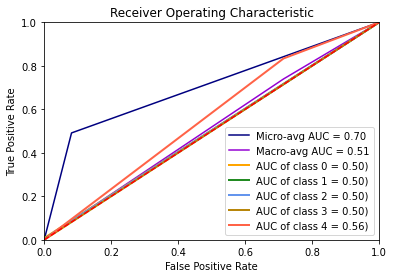

Loading training set at expr_data/bt/10/r10/expr_bt_n10_r10_amazon_reviews_digital_music.json


Running amazon experiment on bt, N10, run# 10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.037     0.005     0.008       220
           2      0.000     0.000     0.000       201
           3      0.094     0.041     0.057       604
           4      0.315     0.197     0.242      1662
           5      0.606     0.823     0.698      3783

    accuracy                          0.536      6470
   macro avg      0.210     0.213     0.201      6470
weighted avg      0.445     0.536     0.476      6470


Test set
AUC: 0 {'macro': 0.5069583109330065, 'micro': 0.6982805255023184, 0: 0.5001927272727272, 1: 0.5, 2: 0.5001532571807904, 3: 0.5, 4: 0.5344455702115147}
Accuracy: 48.5162%


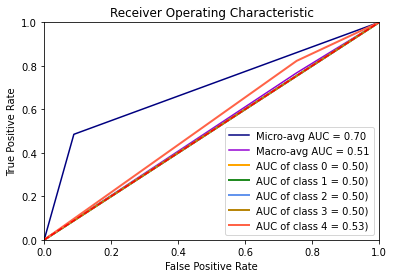

/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/

Loading training set at expr_data/bt/10/r11/expr_bt_n10_r11_amazon_reviews_digital_music.json


Running amazon experiment on bt, N10, run# 11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Applications/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


max_iter reached after 0 seconds
              precision    recall  f1-score   support

           1      0.214     0.027     0.048       220
           2      0.045     0.035     0.039       201
           3      0.070     0.018     0.029       604
           4      0.320     0.250     0.281      1662
           5      0.622     0.795     0.698      3783

    accuracy                          0.533      6470
   macro avg      0.254     0.225     0.219      6470
weighted avg      0.461     0.533     0.486      6470


Test set
AUC: 0 {'macro': 0.5143332258143891, 'micro': 0.692774343122102, 0: 0.5118763636363637, 1: 0.5056088198344694, 2: 0.49666136428808505, 3: 0.5, 4: 0.5575195813130274}
Accuracy: 46.8315%


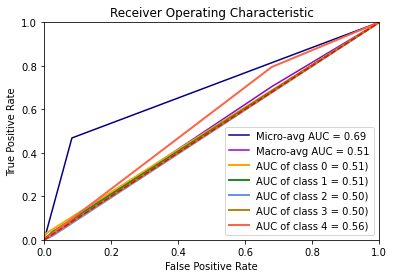

Finished. Please see the experiment metrics report at results/amazon_10_softmax_report.md


In [15]:
RUN_IDS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
EXPR_TYPES = ["orig", "para", "para_tc", "para_editdist", "para_tc_editdist", "tc", "tc_editdist", "eda", "bt"]

for expr_type in EXPR_TYPES:
    for run_id in RUN_IDS:
        train_path = get_train_path(expr_type, NUM_SAMPLES, run_id, DATASET_FILENAME, FILE_EXT)
        print("Loading training set at {0}".format(train_path))
        train = dataset_io.to_df(train_path)
        train_labels = normalize_labels(train, LABEL_FIELD)
        print("\n\nRunning {0} experiment on {1}, N{2}, run# {3}".format(
            DATASET_TYPE, expr_type, NUM_SAMPLES, run_id))
        test_preds = run_and_eval(train, TEST, TEXT_FIELD, LABEL_FIELD, _TEST_LABELS, NUM_CLASSES, DATASET_TYPE)
        get_metrics_report(train, TEST, test_preds, _TEST_LABELS, 
                          train_path, TEST_PATH, LABEL_FIELD, 
                          DATASET_TYPE, expr_type, NUM_SAMPLES, run_id, REPORT_RESULTS_PATH)

print("Finished. Please see the experiment metrics report at {0}".format(REPORT_RESULTS_PATH))